<a href="https://colab.research.google.com/github/HariniJ09/Springboard/blob/master/Capstone_Project_Predicting_Severity_of_Accidents_in_UK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests 
import datetime as datetime
import calendar
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, roc_auc_score, recall_score, classification_report
sns.set()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
pip install ppscore

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for ppscore: filename=ppscore-1.0.0-py2.py3-none-any.whl size=12427 sha256=3e02ceb72eabd595cee96ff794898ac19c5f2e250ed5182d6cc18bbde2261915
  Stored in directory: /root/.cache/pip/wheels/20/50/9c/eb129e849166531526f18d596da06b45eb5077e5edb406eeba
Successfully built ppscore


In [ ]:
print(np.__version__)
print(pd.__version__)

1.18.5
1.0.5


In [ ]:
import sys

print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [ ]:
#from pycaret.classification import * 

In [2]:
veh_df = pd.read_csv('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2018.csv')
cas_df = pd.read_csv('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2018.csv')
acc_df = pd.read_csv('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Accidents_2018.csv') #, index_col='Accident_Index')
lookup_df= pd.read_excel("http://data.dft.gov.uk/road-accidents-safety-data/variable%20lookup.xls",sheet_name=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
acc = acc_df.copy()
acc.columns
acc.replace(-1, np.nan, inplace=True)
acc.isna().any()
acc.info()
acc.shape
#(122635,32)
acc_clean = acc.dropna(axis=0)
acc_clean.shape
#(62748, 32)
acc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122635 entries, 0 to 122634
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               122635 non-null  object 
 1   Location_Easting_OSGR                        122580 non-null  float64
 2   Location_Northing_OSGR                       122580 non-null  float64
 3   Longitude                                    122580 non-null  float64
 4   Latitude                                     122580 non-null  float64
 5   Police_Force                                 122635 non-null  int64  
 6   Accident_Severity                            122635 non-null  int64  
 7   Number_of_Vehicles                           122635 non-null  int64  
 8   Number_of_Casualties                         122635 non-null  int64  
 9   Date                                         122635 non-nul

It is clear that if we try to drop the rows with 'unknown' (encoded as '-1') values, we end up loosing 50% of the data. We will hence keep them.

In [4]:
acc_df.dtypes
#acc_df.columns
#acc_df['col'] = acc_df['col'].astype("int")

Accident_Index                                  object
Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                      int64
Junction_D

Let us make sure to convert all the features to an numerical value so we could analyse and model them.

In [5]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122635 entries, 0 to 122634
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               122635 non-null  object 
 1   Location_Easting_OSGR                        122580 non-null  float64
 2   Location_Northing_OSGR                       122580 non-null  float64
 3   Longitude                                    122580 non-null  float64
 4   Latitude                                     122580 non-null  float64
 5   Police_Force                                 122635 non-null  int64  
 6   Accident_Severity                            122635 non-null  int64  
 7   Number_of_Vehicles                           122635 non-null  int64  
 8   Number_of_Casualties                         122635 non-null  int64  
 9   Date                                         122635 non-nul

Let's convert Date, Time to a datetime objects


In [8]:
acc_df.Date = pd.to_datetime(acc_df.Date)
acc_df.Time = pd.to_datetime(acc_df.Time)


In [7]:
''' We must encode the following columns - Accident_Index(later), Local_Authority_(Highway). 
Since LSOA_of_Accident_Location(Lower Super Ouput Area of Accident_Location (England & Wales only)) is location specific
we can get this informaton from Lat/Long, hence we will go ahead and ignore this columns'''

#le = LabelEncoder()
#acc_df['Local_Authority_(Highway)'] = le.fit_transform(acc_df['Local_Authority_(Highway)'])


' We must encode the following columns - Accident_Index(later), Local_Authority_(Highway). \nSince LSOA_of_Accident_Location(Lower Super Ouput Area of Accident_Location (England & Wales only)) is location specific\nwe can get this informaton from Lat/Long, hence we will go ahead and ignore this columns'

We are eliminating columns that we see less to no dependance to our predicting of severity of a given accident. 

In [4]:
acc_df.isnull().values.any()
acc_df.isnull().sum()
#acc_df.isnull().sum().sum()


Accident_Index                                    0
Location_Easting_OSGR                            55
Location_Northing_OSGR                           55
Longitude                                        55
Latitude                                         55
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                             13
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

Location_Easting & Location_Northing and LSOA_of_Accident_Location - All of these location based parameters can be derived using Lat, Long, so we could drop these columns.

Let's see if the 55 values of Latitude & Longitude are for the same data points.


In [5]:
acc_df[acc_df.Latitude.isna()].equals(acc_df[acc_df.Longitude.isna()])

True

Looks like yes! Lets drop the rows with missing values of Lat/Long.

Let's make sure the missing values of Location_*OSGR, Lat/Long and LSOA*Location are indeed for the same set of data points.

We see that there are few entries( lat,long, Location_easting & Location_northing, Time and LSOA (Lower Super Output Area)) which have missing values, we will discard them since we cannot extrapolate values from the table. We will also remove 'Day_of_Week' since the day can be extracted from the 'Date' column.

In [6]:
acc_df.dropna(axis=0, subset=['Longitude','Latitude','Location_Easting_OSGR','Location_Northing_OSGR','Time'],inplace=True, )
acc_df.drop(axis=1, columns=['LSOA_of_Accident_Location','Day_of_Week'],inplace=True)
acc_df.isnull().sum()


Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                               0
2nd_Road_Class                                 0
2nd_Road_Number     

Data is Clean!
Next we want to see if there is any correlation between Time and Severity of the accident. We convert the Date and Time to datetime type to do so.

In [ ]:
acc_df.Date
acc_df.Date.dt.year.value_counts()

2018    122567
Name: Date, dtype: int64

We observe that this information is only from year 2018 and has about ~125K datapoints.

In [ ]:
acc_df.dtypes

Accident_Index                                         object
Location_Easting_OSGR                                 float64
Location_Northing_OSGR                                float64
Longitude                                             float64
Latitude                                              float64
Police_Force                                            int64
Accident_Severity                                       int64
Number_of_Vehicles                                      int64
Number_of_Casualties                                    int64
Date                                           datetime64[ns]
Time                                           datetime64[ns]
Local_Authority_(District)                              int64
Local_Authority_(Highway)                              object
1st_Road_Class                                          int64
1st_Road_Number                                         int64
Road_Type                                               int64
Speed_li

Let's analyse the trend of accident (and its severity) based on month of the year.

In [9]:
'Lets extract Month from the Date column just for data viz'
acc_df['Month'] = acc_df.Date.dt.month



In [10]:
acc_per_month = pd.pivot_table(acc_df , values = 'Number_of_Casualties' , index = 'Month' , columns = 'Accident_Severity',aggfunc=len, margins=True, margins_name='Total')
acc_per_month.iloc[:-1,:]

Accident_Severity,1,2,3,Total
Month,,,,
1,140,1845,8316,10301
2,116,1615,7292,9023
3,131,1713,7599,9443
4,126,1923,7696,9745
5,151,2090,8602,10843
6,136,2180,8782,11098
7,146,2047,8296,10489
8,132,1843,7770,9745
9,155,2036,8558,10749


In [11]:
days = [calendar.day_abbr[i] for i in range(0,7)]
months = [calendar.month_abbr[i] for i in range(1,13)]

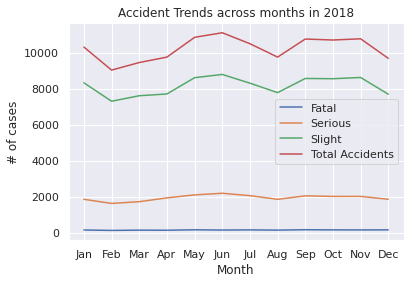

In [ ]:
acc_per_month.iloc[:-1,:].plot(kind='line')
plt.xticks(np.arange(1,13,1),months)
plt.ylabel("# of cases")
plt.legend(labels=["Fatal","Serious","Slight","Total Accidents"])
plt.title("Accident Trends across months in 2018")
plt.show()

We see that the total number of accidents typically peaks mid of the year and is least in February. However the Fatal Accident cases remain constant throughout the year.

Lets plot a heatmap to analyze the trend of accidents across different months.

In [12]:
''' To extract the name of the month to label the plot'''
acc_df['mon_name'] = acc_df['Month'].apply(lambda x: calendar.month_abbr[x])


In [13]:
''' To extract the hour of the day to label the plot'''

acc_df['hour'] = acc_df.Time.dt.hour
hours= sorted(acc_df.hour.unique())


In [14]:
print(acc_df.Date.dt.dayofweek.apply(lambda x: calendar.day_abbr[x]).unique())
acc_df['day'] = acc_df.Date.dt.dayofweek.apply(lambda x: calendar.day_abbr[x])


['Mon' 'Thu' 'Sun' 'Tue' 'Fri' 'Wed' 'Sat']


In [ ]:
acc_df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,mon_name,hour,day
0,2018010080971,529150.0,182270.0,-0.139737,51.524587,1,3,2,2,2018-01-01,2020-08-14 01:30:00,2,E09000007,3,501,3,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,1,Jan,1,Mon
1,2018010080973,542020.0,184290.0,0.046471,51.539651,1,3,1,1,2018-01-01,2020-08-14 00:50:00,17,E09000025,4,165,6,30,2,4,6,0,0,0,4,1,1,0,0,1,1,1,Jan,0,Mon
2,2018010080974,531720.0,182910.0,-0.102474,51.529746,1,3,2,1,2018-01-01,2020-08-14 00:45:00,3,E09000019,3,1,6,20,6,4,5,0,0,5,4,1,1,0,0,1,1,1,Jan,0,Mon
3,2018010080981,541450.0,183220.0,0.037828,51.530179,1,2,2,1,2018-01-01,2020-08-14 03:00:00,17,E09000025,4,167,3,30,7,2,3,124,0,5,4,2,2,0,0,1,1,1,Jan,3,Mon
4,2018010080982,543580.0,176500.0,0.065781,51.469258,1,2,2,2,2018-01-01,2020-08-14 02:20:00,6,E09000011,3,207,6,30,0,-1,-1,0,0,0,4,1,2,0,0,1,1,1,Jan,2,Mon


In [15]:
ac_df = acc_df.copy()
ac_df.day = pd.Categorical(ac_df.day,categories=days)
ac_df.mon_name = pd.Categorical(ac_df.mon_name, categories=months)
ac_df = ac_df.sort_values(['day','mon_name'])
ac_df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,mon_name,hour,day
0,2018010080971,529150.0,182270.0,-0.139737,51.524587,1,3,2,2,2018-01-01,2020-08-18 01:30:00,2,E09000007,3,501,3,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,1,Jan,1,Mon
1,2018010080973,542020.0,184290.0,0.046471,51.539651,1,3,1,1,2018-01-01,2020-08-18 00:50:00,17,E09000025,4,165,6,30,2,4,6,0,0,0,4,1,1,0,0,1,1,1,Jan,0,Mon
2,2018010080974,531720.0,182910.0,-0.102474,51.529746,1,3,2,1,2018-01-01,2020-08-18 00:45:00,3,E09000019,3,1,6,20,6,4,5,0,0,5,4,1,1,0,0,1,1,1,Jan,0,Mon
3,2018010080981,541450.0,183220.0,0.037828,51.530179,1,2,2,1,2018-01-01,2020-08-18 03:00:00,17,E09000025,4,167,3,30,7,2,3,124,0,5,4,2,2,0,0,1,1,1,Jan,3,Mon
4,2018010080982,543580.0,176500.0,0.065781,51.469258,1,2,2,2,2018-01-01,2020-08-18 02:20:00,6,E09000011,3,207,6,30,0,-1,-1,0,0,0,4,1,2,0,0,1,1,1,Jan,2,Mon


In [56]:
mon_vs_day = pd.pivot_table(ac_df, values = 'Number_of_Casualties', index = 'mon_name',columns = 'day', aggfunc=len)


In [ ]:
mon_vs_day

day,Mon,Tue,Wed,Thu,Fri,Sat,Sun
mon_name,,,,,,,
Jan,1561,1889,1674,1394,1601,1174,1008
Feb,1212,1335,1372,1203,1529,1194,1178
Mar,1335,1270,1390,1585,1596,1290,977
Apr,1500,1113,1282,1696,1438,1397,1319
May,1482,1773,1672,1699,1555,1481,1181
Jun,1433,1554,1593,1630,1913,1723,1252
Jul,1818,1601,1340,1532,1475,1293,1430
Aug,1163,1170,1583,1587,1765,1202,1275
Sep,1573,1449,1411,1525,1591,1715,1485


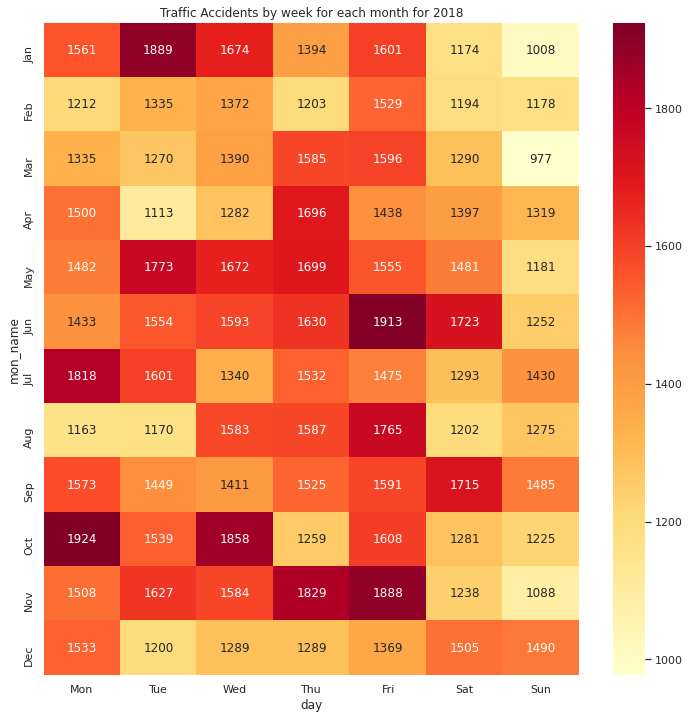

In [ ]:
fig = plt.figure(figsize=(12,12))
map1 = sns.heatmap(mon_vs_day, annot=True, fmt="d", cmap='YlOrRd', cbar_kws={"orientation": "vertical"} )
map1.set_title("Traffic Accidents by week for each month for 2018")
plt.show()

We see that Thursdays & Fridays (closer the weekend) seem to have maximum number of accidents.The numbers are higher during Novemeber( may be Thanksgiving and Summer holidays or a major public event?) too.

In [57]:
day_vs_time = pd.pivot_table(ac_df, values='Number_of_Casualties', index = 'hour' , columns = 'day', aggfunc = len)
day_vs_time.head()

day,Mon,Tue,Wed,Thu,Fri,Sat,Sun
hour,,,,,,,
0,226,208,179,209,265,334,414
1,138,124,111,127,187,264,314
2,124,103,110,108,119,212,277
3,92,99,82,91,108,155,207
4,95,89,103,106,81,158,166


Plotting a heatmap of hour of the day of accident with severity gives the following. Clearly the rush hours (work transit hours - between 7a-9a and 3p-6p) are when the accidents are the highest.

Text(0.5, 1.0, 'Traffic Accidents by hour for each day for 2018')

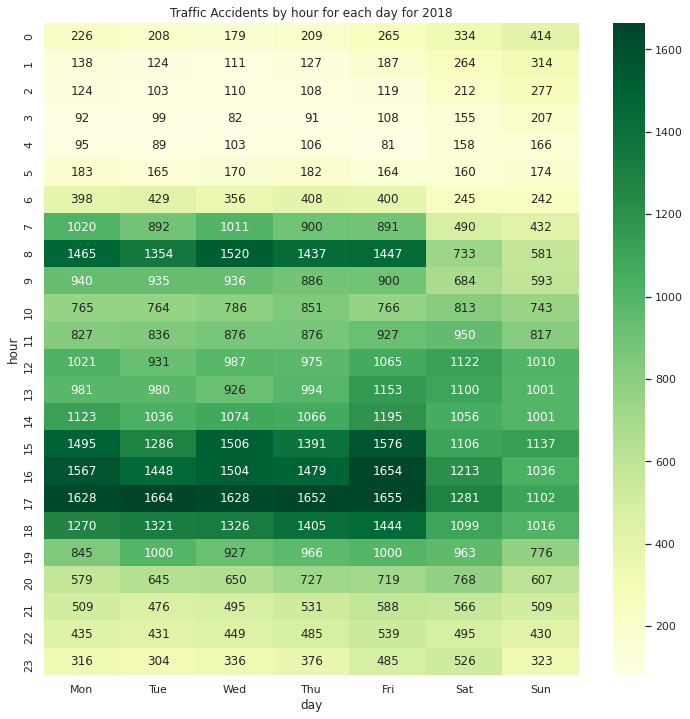

In [ ]:

fig = plt.figure(figsize=(12,12))
map1 = sns.heatmap(day_vs_time, annot=True, fmt="d", cmap='YlGn', cbar_kws={"orientation": "vertical"} )
map1.set_title("Traffic Accidents by hour for each day for 2018")


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc7199a22f0> (for post_execute):


KeyboardInterrupt: ignored

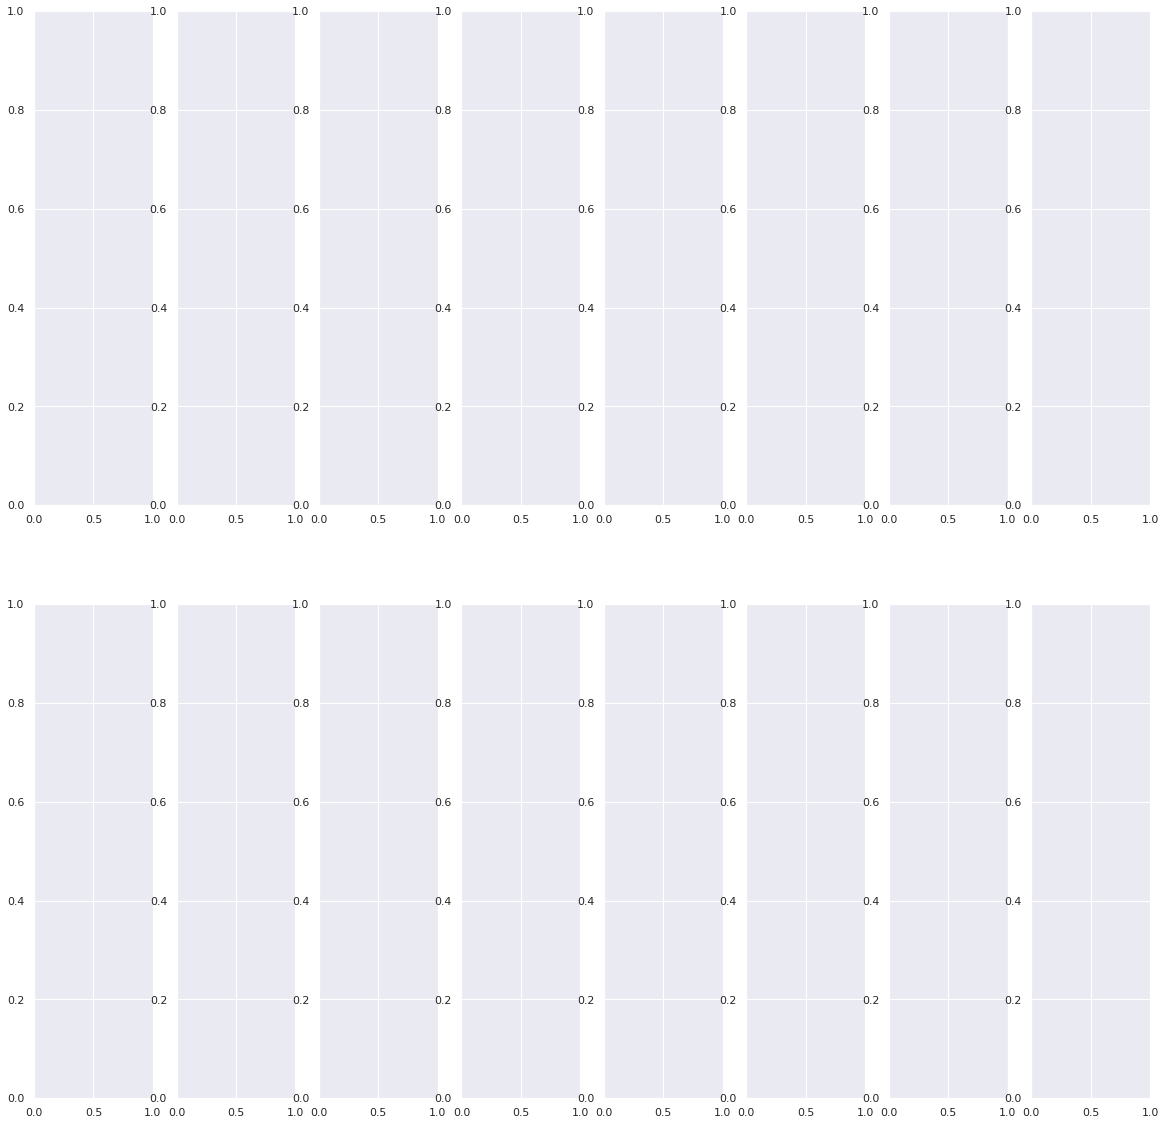

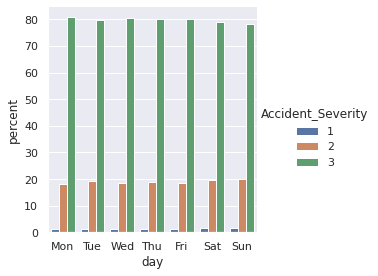

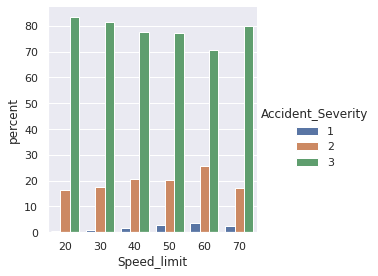

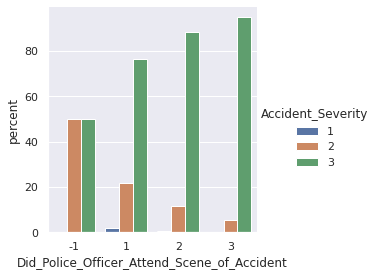

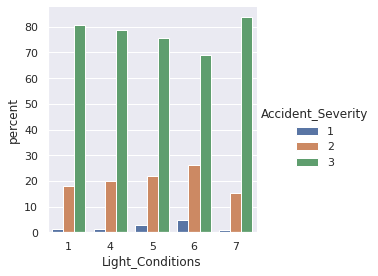

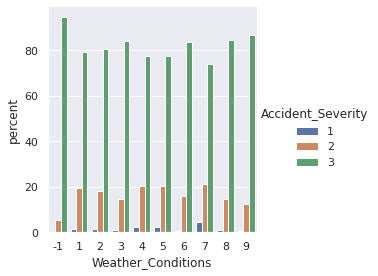

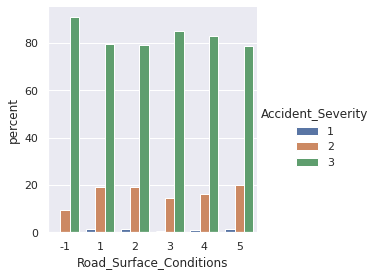

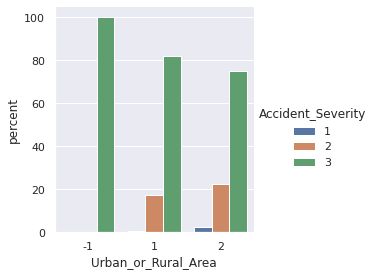

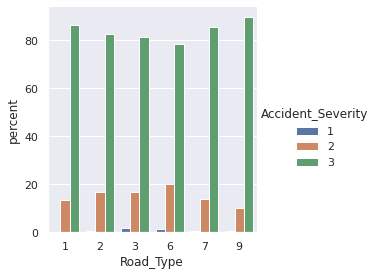

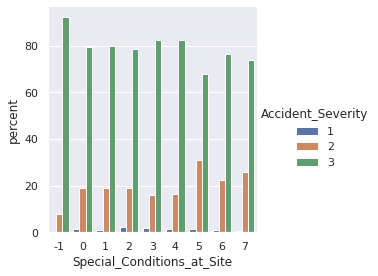

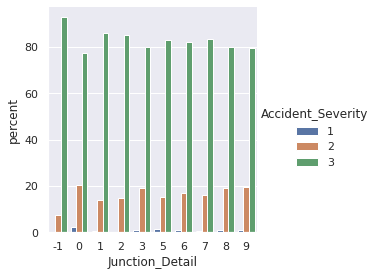

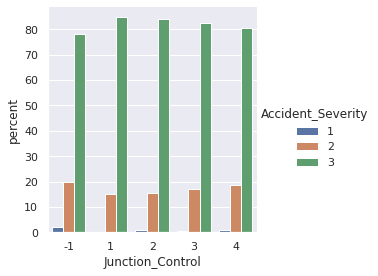

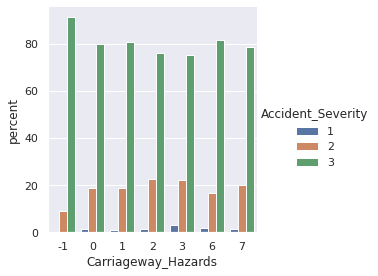

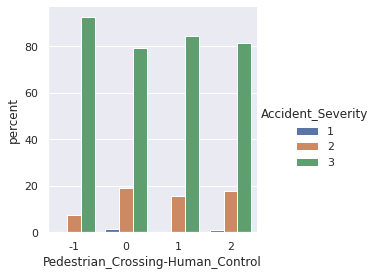

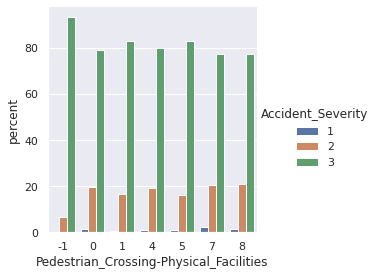

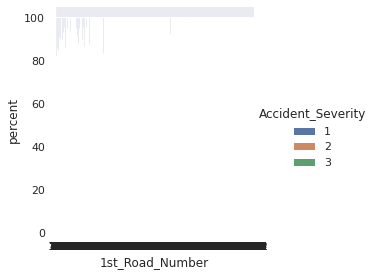

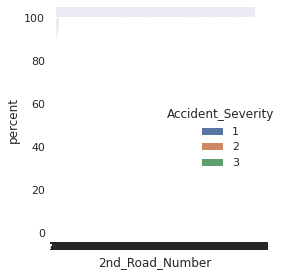

In [ ]:
''' Plotting various feature dependencies to Accident Severity'''

cols = ["day", "Speed_limit", "Did_Police_Officer_Attend_Scene_of_Accident",\
        "Light_Conditions", "Weather_Conditions", 'Road_Surface_Conditions','Urban_or_Rural_Area','Road_Type','Special_Conditions_at_Site',
        'Junction_Detail','Junction_Control','Carriageway_Hazards','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', \
        "1st_Road_Number","2nd_Road_Number"]


fig,a = plt.subplots(2,8, figsize=(20,20))
a = a.reshape(-1)
for idx, ax in  enumerate(a):
  df1 = ac_df.groupby(cols[idx])['Accident_Severity'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
  #df1 = df1.mul(100)
  #df1 = df1.rename('percent').reset_index()
  #sns.set(rc={"axes.grid":True})
  p = sns.catplot(x=cols[idx],y='percent',hue='Accident_Severity',kind='bar',sharey=False, data=df1,\
                   height=4, aspect=1, ax=ax)
  # for patch in ax.patches:
  #   percentage = '{:.1f}%'.format(100 * patch.get_width()/total)
  #   print("PATCH WIDTH AND HEIGHT",patch.get_width(),patch.get_height())
  #   x = patch.get_x() + patch.get_width() + 0.02
  #   y = patch.get_y() + patch.get_height()/2
  #   ax.annotate(percentage, (x, y))
  #plt.legend(["Fatal","Serious","Slight"])
  #ax.set_title(cols[idx])
plt.show()


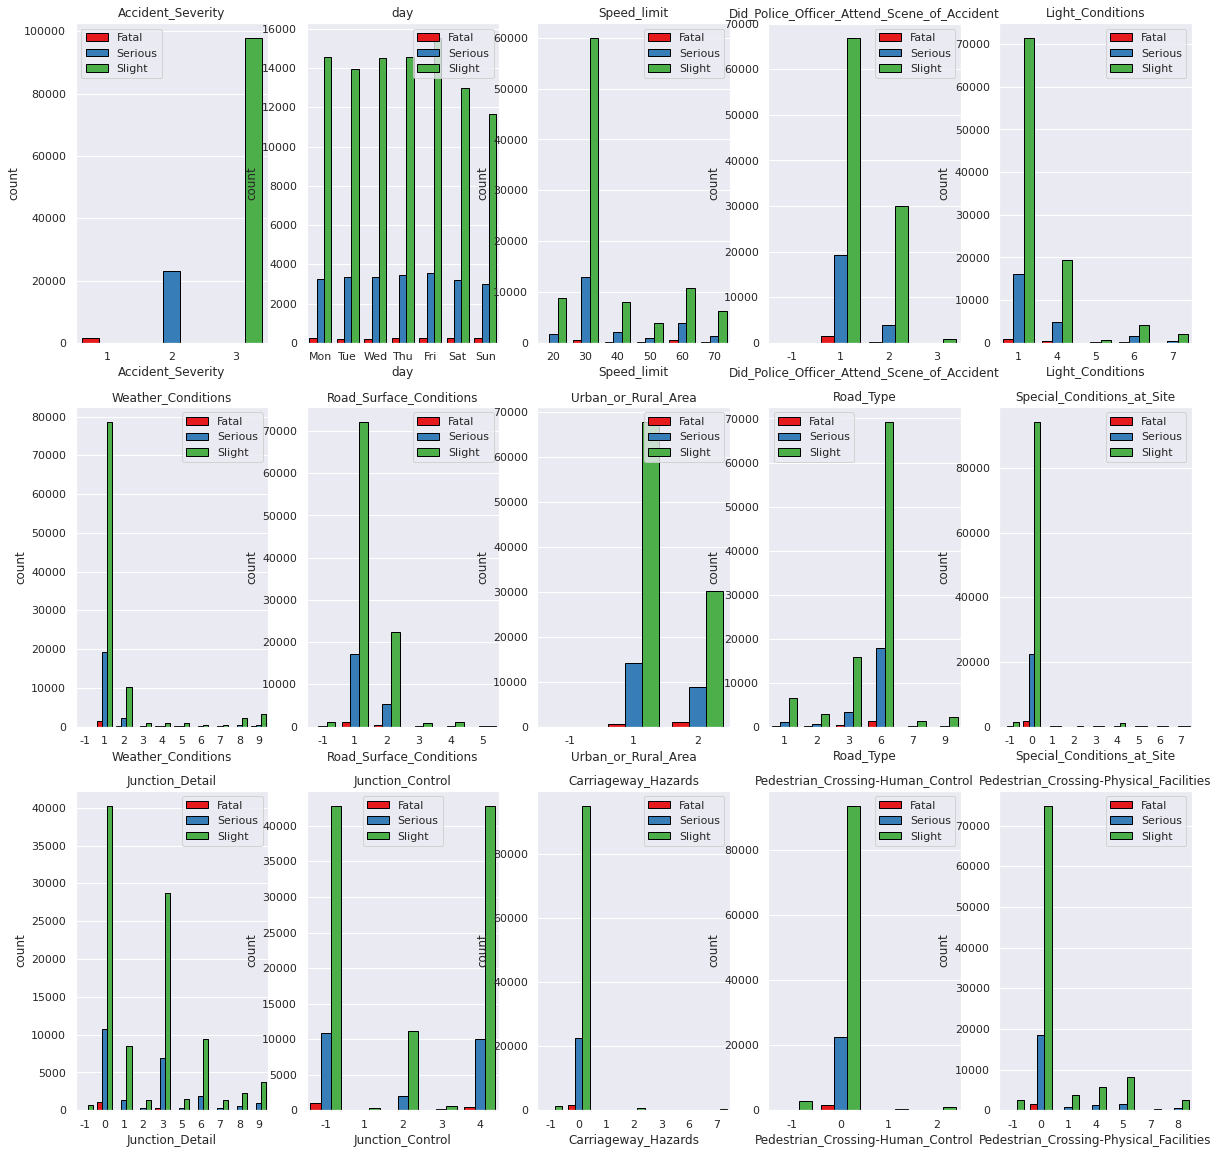

In [ ]:
''' Plotting categorical feature dependencies against Accident Severity'''

cols = ["Accident_Severity","day", "Speed_limit", "Did_Police_Officer_Attend_Scene_of_Accident",\
        "Light_Conditions", "Weather_Conditions", 'Road_Surface_Conditions','Urban_or_Rural_Area','Road_Type','Special_Conditions_at_Site',
        'Junction_Detail','Junction_Control','Carriageway_Hazards','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities']


fig,a = plt.subplots(3,5, figsize=(20,20))
a = a.reshape(-1)
for idx, ax in  enumerate(a):
  sns.set(rc={"axes.grid":True})
  p = sns.countplot(x=cols[idx], data=ac_df, hue='Accident_Severity'\
  , ax=ax, palette='Set1', saturation=1, edgecolor=(0,0,0), linewidth=1)
  p.legend(labels=["Fatal","Serious","Slight"], loc = 'best')
  ax.set_title(cols[idx])
plt.show()


From the above plots we see that the number of fatal accidents are really skewed and number of 'Slight' is significantly high followed by 'Serious'.

In [58]:
acc_df.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Month', 'mon_name', 'hour', 'day'],
      dtype='object')

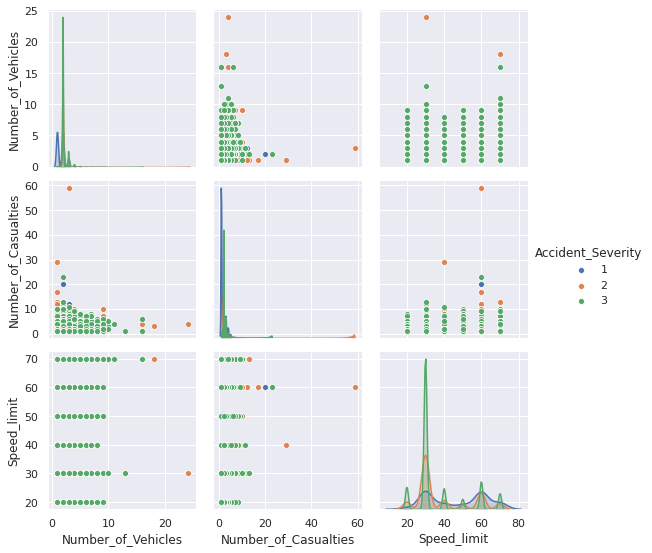

In [ ]:
''' Plotting continuous feature against the Accident Severity'''
cols = ["Number_of_Vehicles", "Number_of_Casualties","Accident_Severity","Speed_limit"]
sns.pairplot(acc_df[cols], hue='Accident_Severity')


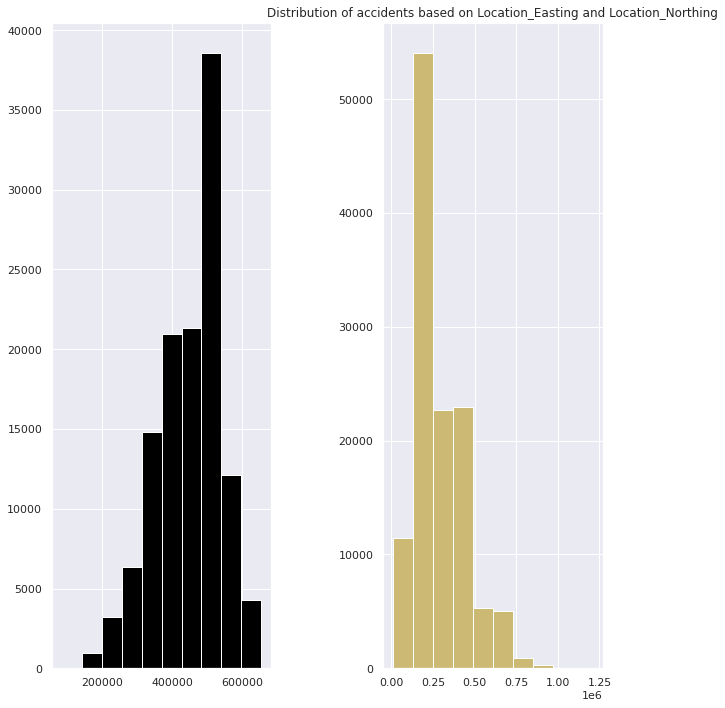

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
plt.title("Distribution of accidents based on Location_Easting and Location_Northing")
axes[0].hist(acc_df['Location_Easting_OSGR'],color='black')
axes[1].hist(acc_df['Location_Northing_OSGR'],color='y')
fig.tight_layout()

Let us now take a look at how continuous variables are related to the accident severity


Accident_Severity    1      2      3
Light_Conditions                    
1                  974  16086  71335
4                  347   4899  19479
5                   24    186    646
6                  300   1595   4219
7                   24    382   2071


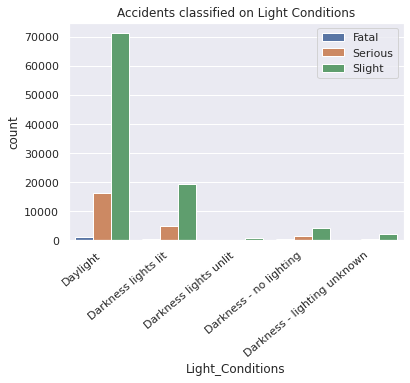

In [ ]:
import seaborn as sns
light_labels = ["Daylight", "Darkness lights lit", "Darkness lights unlit", "Darkness - no lighting", "Darkness - lighting unknown", "Data missing or out of range"]
light_severitycasesCount = acc_df.groupby(['Light_Conditions', 'Accident_Severity'])['Number_of_Casualties'].count().unstack()
print(light_severitycasesCount)
plot = sns.countplot(x="Light_Conditions",data=acc_df, hue='Accident_Severity')
plot.set_xticklabels(light_labels, rotation=40, ha="right")
plot.legend(['Fatal','Serious','Slight'])
plt.title("Accidents classified on Light Conditions")
plt.show()

Similarly we see the ratio of Slight and Serious pretty high compared to Fatal accidents. We also see that most accidents happens in broad daylight or when lights are lit.

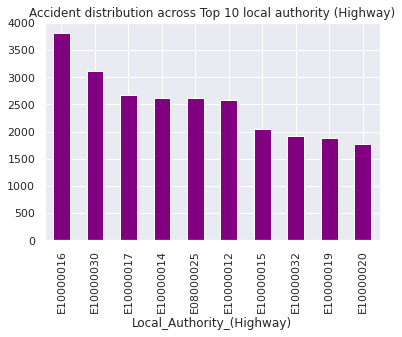

In [ ]:
acc_df.groupby(['Local_Authority_(Highway)'])['Number_of_Casualties'].count().nlargest(10).plot(kind='bar',color='purple')
plt.title('Accident distribution across Top 10 local authority (Highway)')
plt.show()

We see maximum accidents happening at Locations Kent, Surrey followed by Lancashire, Hampshire, Oxfordshire, Essex.


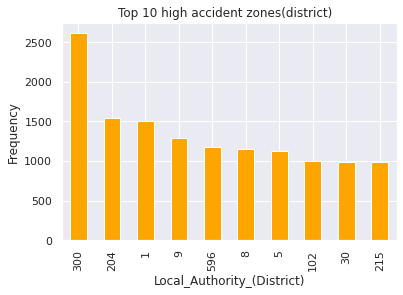

In [ ]:
acc_df.groupby(['Local_Authority_(District)'])['Number_of_Casualties'].count().nlargest(10).plot(kind='bar',color='orange')
plt.title('Top 10 high accident zones(district)  ')
plt.ylabel('Frequency')
plt.show()

We see that the local authority with highest accident cases is: 'Birmingham' followed by 'Leeds' and 'Westminister'.

We see that Fatal and Slight accidents happens most at not a junction, followed by T-junctions, roundabouts and crossroads. Regarding junction control, most of the accidents happens in places where details are unknown. However it is clear that Fatal accidents happens the most at junctions that are a give-way or uncontrolled. 
Seems accidents happen the most when there is no carriage way hazards.
Similarly there were no pedestrian crossing at the majority of accident sites, with human control.
Most accidents happened with no physical crossing facilities within 50 meters. However the number of Serious accidents happened when it was pedestrian's turn to cross the road.
Looks like Police always arrives at the situation for Fatal accidents all the times. However there were 50% of times they did not arrive for a Slight and Serious accidents as much. 


We also have information of the vehicles and the casuality details that are involved in each accident. These are stored in veh_df and cas_df. These data can be merged with the acc_df (accident details) based on the accident index (this is why we retain the accident_index as object). We also observe that there are 2 targets that are similar - Accident index and casuality index. Since they are very similar, we will drop the 'Accident Severity'. Following are some data cleaning and merging of the data frames.

In [66]:
print(veh_df.isnull().values.any())
print(cas_df.isnull().sum())
#acc_df.isnull().sum().sum()
print(veh_df.duplicated().any())
print(cas_df.duplicated().any())

False
Accident_Index                        0
Vehicle_Reference                     0
Casualty_Reference                    0
Casualty_Class                        0
Sex_of_Casualty                       0
Age_Band_of_Casualty                  0
Casualty_Severity                     0
Pedestrian_Location                   0
Car_Passenger                         0
Bus_or_Coach_Passenger                0
Pedestrian_Road_Maintenance_Worker    0
Casualty_Type                         0
Casualty_Home_Area_Type               0
dtype: int64
False
False


In [ ]:
print(cas_df.dtypes)
print(cas_df.shape)
cas_df.head()


Accident_Index                        object
Vehicle_Reference                      int64
Casualty_Reference                     int64
Casualty_Class                         int64
Sex_of_Casualty                        int64
Age_of_Casualty                        int64
Age_Band_of_Casualty                   int64
Casualty_Severity                      int64
Pedestrian_Location                    int64
Pedestrian_Movement                    int64
Car_Passenger                          int64
Bus_or_Coach_Passenger                 int64
Pedestrian_Road_Maintenance_Worker     int64
Casualty_Type                          int64
Casualty_Home_Area_Type                int64
Casualty_IMD_Decile                    int64
dtype: object
(160597, 16)


,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2018010080971,1,1,2,2,50,8,3,0,0,2,0,0,9,1,8
1,2018010080971,2,2,1,1,48,8,3,0,0,0,0,0,8,1,1
2,2018010080973,1,1,3,1,29,6,3,5,1,0,0,2,0,1,3
3,2018010080974,1,1,1,1,40,7,3,0,0,0,0,0,8,1,3
4,2018010080981,1,1,1,1,27,6,2,0,0,0,0,0,9,1,7


In [59]:
#sns.distplot(cas_df['Casualty_Severity'])
#cas_df['Casualty_Severity'].plot(kind='box', subplots=True)
#cas_df.corr()

We can see that Age_Band and Age_of_Casualty are same thing notated differently. Since Its easier to visualize and model with ranges. Lets eliminate the 'Age_of_Casualty' columns.
Similarly, Pedestrian location and movement seem correlated. We can skip movement and choose just the former.
We see the IMD Decile are not very related to the Severity, so lets remove that.

In [60]:
cas_df.drop(['Age_of_Casualty','Pedestrian_Movement','Casualty_IMD_Decile'],axis=1, inplace=True)

In [18]:
import ppscore as pps

In [67]:
cas_pps_predictors = pps.predictors(cas_df,y='Casualty_Severity')

In [68]:
cas_pps_predictors

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Accident_Index,Casualty_Severity,0,regression,True,mean absolute error,0.1780,0.179400,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
1,Vehicle_Reference,Casualty_Severity,0,regression,True,mean absolute error,0.1860,0.305624,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
2,Casualty_Reference,Casualty_Severity,0,regression,True,mean absolute error,0.1866,0.306147,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
3,Casualty_Class,Casualty_Severity,0,regression,True,mean absolute error,0.1802,0.295470,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
4,Sex_of_Casualty,Casualty_Severity,0,regression,True,mean absolute error,0.1712,0.284953,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
5,Age_Band_of_Casualty,Casualty_Severity,0,regression,True,mean absolute error,0.1780,0.293959,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
6,Pedestrian_Location,Casualty_Severity,0,regression,True,mean absolute error,0.1934,0.314014,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
7,Car_Passenger,Casualty_Severity,0,regression,True,mean absolute error,0.1818,0.299574,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
8,Bus_or_Coach_Passenger,Casualty_Severity,0,regression,True,mean absolute error,0.1860,0.306419,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
9,Pedestrian_Road_Maintenance_Worker,Casualty_Severity,0,regression,True,mean absolute error,0.1802,0.298514,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


In [ ]:
#pps.matrix(cas_df)

In [ ]:
#pps.matrix(acc_df)

In [ ]:
#pps.matrix(veh_df)


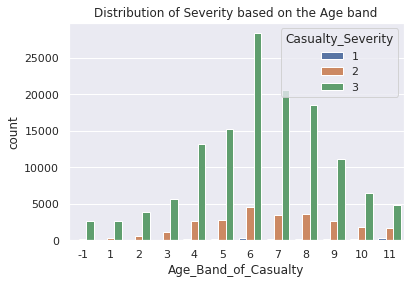

In [ ]:
sns.countplot(cas_df['Age_Band_of_Casualty'],data=cas_df, hue='Casualty_Severity')
plt.title("Distribution of Severity based on the Age band")
plt.show()



We see that the accidents that involves the most is the age and of 26-35 followed by 36-45.

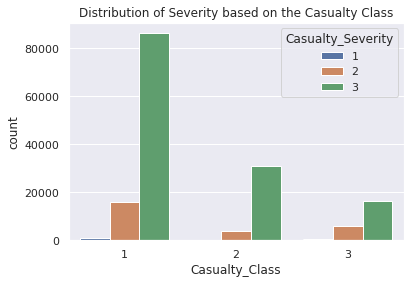

In [ ]:
sns.countplot(cas_df['Casualty_Class'],data=cas_df, hue='Casualty_Severity')
plt.title("Distribution of Severity based on the Casualty Class")
#1 - Driver, 2 - Passenger, 3- Pedestrian
plt.show()




From the plot above we see that Drivers are disproportionately affected during an accident, almost 3 times more vulnerable than a Passenger or Pedestrian, irrespective of the severity of the accident.

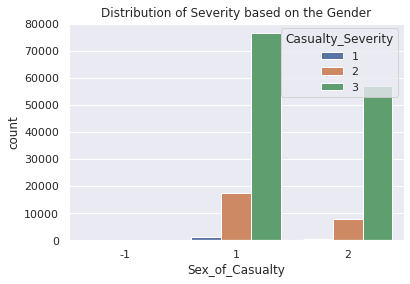

In [ ]:
sns.countplot(cas_df['Sex_of_Casualty'],data=cas_df, hue='Casualty_Severity')
plt.title("Distribution of Severity based on the Gender")
plt.show()
# 1- Male, 2 - Female


We see that male are involved in accidents more, almost 25% more than female are. The severity of fatal is high in accidents involving male.

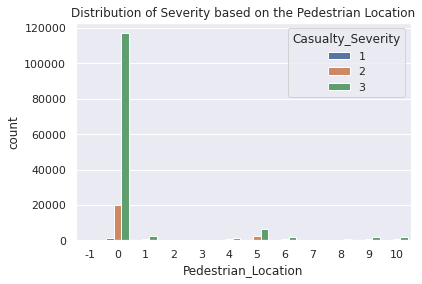

In [ ]:
sns.countplot(cas_df['Pedestrian_Location'],data=cas_df, hue='Casualty_Severity')
plt.title("Distribution of Severity based on the Pedestrian Location")
plt.show()



It is clear that the number of Slight accidents are the most in cases where there are no Pedestrians involved.
The second case is when carriageway, stationary are not crossing  (standing or playing).


Let's cleanup and analyze the Vehicle Dataframe.

In [ ]:
print(veh_df.dtypes)
print(veh_df.shape)
veh_df.head()


Accident_Index                      object
Vehicle_Reference                    int64
Vehicle_Type                         int64
Towing_and_Articulation              int64
Vehicle_Manoeuvre                    int64
Vehicle_Location-Restricted_Lane     int64
Junction_Location                    int64
Skidding_and_Overturning             int64
Hit_Object_in_Carriageway            int64
Vehicle_Leaving_Carriageway          int64
Hit_Object_off_Carriageway           int64
1st_Point_of_Impact                  int64
Was_Vehicle_Left_Hand_Drive?         int64
Journey_Purpose_of_Driver            int64
Sex_of_Driver                        int64
Age_of_Driver                        int64
Age_Band_of_Driver                   int64
Engine_Capacity_(CC)                 int64
Propulsion_Code                      int64
Age_of_Vehicle                       int64
Driver_IMD_Decile                    int64
Driver_Home_Area_Type                int64
Vehicle_IMD_Decile                   int64
dtype: obje

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
0,2018010080971,1,9,0,18,0,0,0,0,0,0,1,1,6,1,32,6,1995,2,5,8,1,8
1,2018010080971,2,8,0,18,0,0,0,0,0,0,2,1,6,1,48,8,1798,8,6,1,1,1
2,2018010080973,1,9,0,18,0,2,0,0,0,0,1,1,6,3,-1,-1,-1,-1,-1,-1,-1,-1
3,2018010080974,1,8,0,7,0,8,0,0,0,0,1,1,1,1,40,7,1797,8,6,3,1,3
4,2018010080974,2,9,0,18,0,1,0,0,3,1,1,1,6,1,21,5,-1,-1,-1,5,1,5


In [69]:
#veh_df.corr()

From below we see that are 56952 missing values under Vehicle_IMD_Decile column. We cant impute these values as these are specific categories, hence it is better to drop this column.

In [70]:
# veh_df.Vehicle_IMD_Decile.value_counts()

In [71]:
# veh_df.Driver_IMD_Decile.value_counts()

In [ ]:
veh_df.describe()

,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
count,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000
mean,1.568891,9.997522,0.013197,12.129708,0.131086,2.155714,0.158942,0.261783,0.268677,0.369848,1.694266,0.927878,4.691170,1.463122,35.517731,5.929424,1443.714751,1.015680,5.726954,3.591779,0.874510,3.591779
std,2.230718,10.909687,0.348416,6.702963,1.166424,3.026446,0.838033,1.600201,1.305326,1.874337,1.209306,0.397497,1.978297,0.664366,20.795952,3.133560,1638.166987,1.463009,6.086947,3.600298,1.090387,3.600298
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,9.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,23.000000,5.000000,125.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
50%,1.000000,9.000000,0.000000,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,6.000000,1.000000,35.000000,6.000000,1398.000000,1.000000,5.000000,3.000000,1.000000,3.000000
75%,2.000000,9.000000,0.000000,18.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,6.000000,2.000000,50.000000,8.000000,1956.000000,2.000000,10.000000,7.000000,1.000000,7.000000
max,999.000000,98.000000,5.000000,18.000000,9.000000,8.000000,5.000000,12.000000,8.000000,11.000000,4.000000,2.000000,6.000000,3.000000,101.000000,11.000000,99999.000000,12.000000,84.000000,10.000000,3.000000,10.000000


In [72]:
veh_df.drop(['Age_of_Driver','Vehicle_IMD_Decile','Driver_IMD_Decile'], axis=1, inplace=True)

Let's index all the three columns with Accident_Index ( changed to str type)

In [ ]:
#cas_df[cas_df['Accident_Index']=='2018010080973']
#cas_df.groupby(['Accident_Index','Vehicle_Reference','Casualty_Reference']).count()

In [ ]:
veh_df.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type
0,2018010080971,1,9,0,18,0,0,0,0,0,0,1,1,6,1,6,1995,2,5,1
1,2018010080971,2,8,0,18,0,0,0,0,0,0,2,1,6,1,8,1798,8,6,1
2,2018010080973,1,9,0,18,0,2,0,0,0,0,1,1,6,3,-1,-1,-1,-1,-1
3,2018010080974,1,8,0,7,0,8,0,0,0,0,1,1,1,1,7,1797,8,6,1
4,2018010080974,2,9,0,18,0,1,0,0,3,1,1,1,6,1,5,-1,-1,-1,1


In [73]:
print("The Accident's DF shape is", acc_df.shape)
print("The Vehicle's DF  shape is", veh_df.shape)
print("The Casualty's DF shape is", cas_df.shape)

The Accident's DF shape is (122567, 34)
The Vehicle's DF  shape is (226409, 20)
The Casualty's DF shape is (160597, 13)


## **Derived Features**

In [19]:
cont_cols = ['Latitude','Longitude', 'Number_of_Vehicles','Number_of_Casualties','Speed_limit','1st_Road_Number','2nd_Road_Number', 'Location_Easting_OSGR','Location_Northing_OSGR']
cat_cols = [cols.strip() for cols in acc_df.columns.values if cols not in cont_cols]
acc_df[cat_cols] = acc_df[cat_cols].astype('category')

**Binning Time of the day (based on heat map), Police force, Local Authority (highway/District)**

In [20]:
acc_df['Traffic'] = pd.cut(acc_df.hour, [0,6,9,13,19,np.inf], labels=['VFree','Busy','Mod','VBusy','Free'], include_lowest=True)

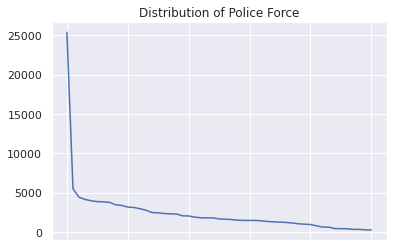

In [21]:
acc_df.Police_Force.value_counts().plot()
plt.title("Distribution of Police Force")
plt.show()

In [22]:
df_pf = pd.DataFrame(acc_df.Police_Force.value_counts()).reset_index()
df_pf.columns=['PF','num_PF']
df_pf.sort_values(by='num_PF').head()


,PF,num_PF
50,98,258
49,48,270
48,96,327
47,94,328
46,93,405


In [23]:
df_pf['pf_bin'] = pd.cut(df_pf.num_PF, [1, 1000, 5000, 15000, np.inf], labels=['S','M','L','XXL'],include_lowest=True)
df_pf.drop(['num_PF'], axis=1, inplace=True)

In [79]:
df_pf.head()

,PF,pf_bin
0,1,XXL
1,20,L
2,46,M
3,13,M
4,44,M


In [24]:
acc_df['Police_Force_Cat'] = acc_df['Police_Force'].map(df_pf.set_index('PF')['pf_bin'])

In [25]:
acc_df.Police_Force_Cat.value_counts()

M      85310
XXL    25384
S       6384
L       5489
Name: Police_Force_Cat, dtype: int64

In [26]:
df_la = pd.DataFrame(acc_df['Local_Authority_(Highway)'].value_counts()).reset_index()
df_la.columns=['LA_Hwy','hwy_cnt']
df_la.sort_values(by='hwy_cnt').head()


,LA_Hwy,hwy_cnt
206,E06000053,2
205,S12000027,14
204,S12000023,14
203,S12000013,21
202,S12000005,35


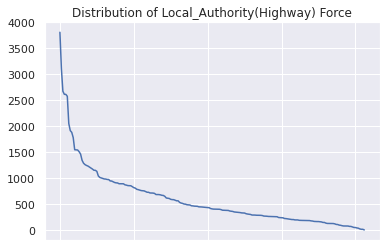

In [27]:
acc_df['Local_Authority_(Highway)'].value_counts().plot()
plt.title("Distribution of Local_Authority(Highway) Force")
plt.show()

In [28]:
df_la['LA_Hwy_bin'] = pd.cut(df_la.hwy_cnt, [0, 1000, 2000, 3000, np.inf], labels=['S','M','L','XXL'],include_lowest=True)
df_la.drop(['hwy_cnt'], axis=1, inplace=True)
df_la.head()

,LA_Hwy,LA_Hwy_bin
0,E10000016,XXL
1,E10000030,XXL
2,E10000017,L
3,E10000014,L
4,E08000025,L


In [29]:
acc_df['LA_Hwy_bin'] = acc_df['Local_Authority_(Highway)'].map(df_la.set_index('LA_Hwy')['LA_Hwy_bin'])
acc_df.LA_Hwy_bin.value_counts()

S      73493
M      29620
L      12532
XXL     6922
Name: LA_Hwy_bin, dtype: int64

In [30]:
df_la = pd.DataFrame(acc_df['Local_Authority_(District)'].value_counts()).reset_index()
df_la.columns=['LA_dst','dst_cnt']
df_la.sort_values(by='dst_cnt').head()



,LA_dst,dst_cnt
379,936,14
378,933,14
377,941,21
376,915,35
375,57,40


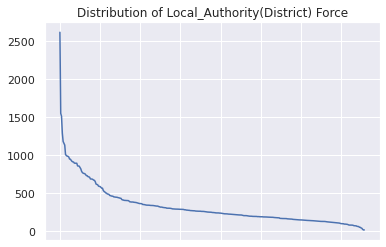

In [31]:
acc_df['Local_Authority_(District)'].value_counts().plot()
plt.title("Distribution of Local_Authority(District) Force")
plt.show()

In [32]:
df_la['LA_dst_bin'] = pd.cut(df_la.dst_cnt, [0, 500, 1000, 2000, np.inf], labels=['S','M','L','XXL'],include_lowest=True)
df_la.drop(['dst_cnt'], axis=1, inplace=True)
df_la.head()
acc_df['LA_dst_bin'] = acc_df['Local_Authority_(District)'].map(df_la.set_index('LA_dst')['LA_dst_bin'])
acc_df.LA_dst_bin.value_counts()


S      73652
M      37495
L       8806
XXL     2614
Name: LA_dst_bin, dtype: int64

In [33]:
acc_df.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Month', 'mon_name', 'hour', 'day', 'Traffic', 'Police_Force_Cat',
       'LA_Hwy_bin', 'LA_dst_bin'],
      dtype='object')

In [34]:
no_need_cols = ['Accident_Index','1st_Road_Number','2nd_Road_Number','Police_Force','Local_Authority_(District)','Local_Authority_(Highway)','hour','Location_Easting_OSGR'	,'Location_Northing_OSGR','Date','Time','Month']
acc_df.drop(columns=no_need_cols,inplace=True)

In [35]:
acc_df.dtypes

Longitude                                       float64
Latitude                                        float64
Accident_Severity                              category
Number_of_Vehicles                                int64
Number_of_Casualties                              int64
1st_Road_Class                                 category
Road_Type                                      category
Speed_limit                                       int64
Junction_Detail                                category
Junction_Control                               category
2nd_Road_Class                                 category
Pedestrian_Crossing-Human_Control              category
Pedestrian_Crossing-Physical_Facilities        category
Light_Conditions                               category
Weather_Conditions                             category
Road_Surface_Conditions                        category
Special_Conditions_at_Site                     category
Carriageway_Hazards                            c

In [ ]:
#acc_df['Casualty_bin'] = pd.cut(acc_df.Number_of_Casualties, [1,3,9,15,30,np.inf], labels=['S','M','L','XL','XXL'], include_lowest=True)

In [ ]:
#acc_df['Vehicles_bin'] = pd.cut(acc_df.Number_of_Vehicles, [0,2,5,10,15,20,np.inf], labels=['S', 'M', 'L', 'XL', 'XXL', 'XXXL'],include_lowest=True)

In [ ]:
#acc_df['Speed_bin'] = pd.cut(acc_df['Speed_limit'], [20, 39, 59, np.inf], labels=['Slow','Mid','High'],include_lowest=True)

In [92]:
acc_df.tail()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,mon_name,day,Traffic,Police_Force_Cat,LA_Hwy_bin,LA_dst_bin
122630,-3.461918,55.232746,3,2,1,3,6,60,0,-1,-1,0,0,1,1,2,0,0,2,1,Dec,Sun,Mod,S,S,S
122631,-3.360440,55.116374,3,2,1,2,3,70,0,-1,-1,0,0,1,1,1,0,0,1,1,Dec,Mon,Mod,S,S,S
122632,-3.264352,55.058510,3,3,1,4,6,30,0,-1,-1,0,0,4,1,2,0,0,2,1,Dec,Thu,VBusy,S,S,S
122633,-3.269695,54.990344,2,1,1,5,6,60,3,4,6,0,0,1,1,4,0,0,2,1,Dec,Mon,Mod,S,S,S
122634,-3.314764,55.006392,3,1,1,4,6,60,0,-1,-1,0,0,6,1,1,0,7,2,2,Dec,Mon,Busy,S,S,S


In [36]:
acc_df.shape

(122567, 26)

In [94]:
acc_df.duplicated().any()

True

In [37]:
dup = acc_df[acc_df.duplicated(keep=False)]

In [38]:
print(acc_df.shape)
print(dup.shape)

(122567, 26)
(16, 26)


In [39]:
acc_df = acc_df.drop_duplicates()

In [40]:
acc_df.head()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,mon_name,day,Traffic,Police_Force_Cat,LA_Hwy_bin,LA_dst_bin
0,-0.139737,51.524587,3,2,2,3,3,30,0,-1,-1,0,0,4,1,1,0,0,1,1,Jan,Mon,VFree,XXL,S,M
1,0.046471,51.539651,3,1,1,4,6,30,2,4,6,0,0,4,1,1,0,0,1,1,Jan,Mon,VFree,XXL,S,M
2,-0.102474,51.529746,3,2,1,3,6,20,6,4,5,0,5,4,1,1,0,0,1,1,Jan,Mon,VFree,XXL,S,M
3,0.037828,51.530179,2,2,1,4,3,30,7,2,3,0,5,4,2,2,0,0,1,1,Jan,Mon,VFree,XXL,S,M
4,0.065781,51.469258,2,2,2,3,6,30,0,-1,-1,0,0,4,1,2,0,0,1,1,Jan,Mon,VFree,XXL,S,M


In [41]:
X = acc_df.drop(['Accident_Severity'], axis=1)
y = acc_df['Accident_Severity']

In [42]:
print('size of X,y',X.shape,y.shape)

size of X,y (122559, 25) (122559,)


In [101]:
X.head()

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,mon_name,day,Traffic,Police_Force_Cat,LA_Hwy_bin,LA_dst_bin
0,-0.139737,51.524587,2,2,3,3,30,0,-1,-1,0,0,4,1,1,0,0,1,1,Jan,Mon,VFree,XXL,S,M
1,0.046471,51.539651,1,1,4,6,30,2,4,6,0,0,4,1,1,0,0,1,1,Jan,Mon,VFree,XXL,S,M
2,-0.102474,51.529746,2,1,3,6,20,6,4,5,0,5,4,1,1,0,0,1,1,Jan,Mon,VFree,XXL,S,M
3,0.037828,51.530179,2,1,4,3,30,7,2,3,0,5,4,2,2,0,0,1,1,Jan,Mon,VFree,XXL,S,M
4,0.065781,51.469258,2,2,3,6,30,0,-1,-1,0,0,4,1,2,0,0,1,1,Jan,Mon,VFree,XXL,S,M


In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122559 entries, 0 to 122634
Data columns (total 25 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   Longitude                                    122559 non-null  float64 
 1   Latitude                                     122559 non-null  float64 
 2   Number_of_Vehicles                           122559 non-null  int64   
 3   Number_of_Casualties                         122559 non-null  int64   
 4   1st_Road_Class                               122559 non-null  category
 5   Road_Type                                    122559 non-null  category
 6   Speed_limit                                  122559 non-null  int64   
 7   Junction_Detail                              122559 non-null  category
 8   Junction_Control                             122559 non-null  category
 9   2nd_Road_Class                               122

In [46]:
cont_cols = ['Latitude','Longitude', 'Number_of_Vehicles','Number_of_Casualties','Speed_limit']
cat_cols = [cols.strip() for cols in X.columns.values if cols not in cont_cols]


In [43]:
X_raw = X.copy()

In [47]:
X_encoded = pd.get_dummies(X, columns=cat_cols, prefix_sep='_', drop_first=True)
X = X_encoded

In [48]:
print(X.shape)
X.head()

(122559, 110)


,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Speed_limit,1st_Road_Class_2,1st_Road_Class_3,1st_Road_Class_4,1st_Road_Class_5,1st_Road_Class_6,Road_Type_2,Road_Type_3,Road_Type_6,Road_Type_7,Road_Type_9,Junction_Detail_0,Junction_Detail_1,Junction_Detail_2,Junction_Detail_3,Junction_Detail_5,Junction_Detail_6,Junction_Detail_7,Junction_Detail_8,Junction_Detail_9,Junction_Control_1,Junction_Control_2,Junction_Control_3,Junction_Control_4,2nd_Road_Class_1,2nd_Road_Class_2,2nd_Road_Class_3,2nd_Road_Class_4,2nd_Road_Class_5,2nd_Road_Class_6,Pedestrian_Crossing-Human_Control_0,Pedestrian_Crossing-Human_Control_1,Pedestrian_Crossing-Human_Control_2,Pedestrian_Crossing-Physical_Facilities_0,Pedestrian_Crossing-Physical_Facilities_1,Pedestrian_Crossing-Physical_Facilities_4,...,Carriageway_Hazards_1,Carriageway_Hazards_2,Carriageway_Hazards_3,Carriageway_Hazards_6,Carriageway_Hazards_7,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2,Did_Police_Officer_Attend_Scene_of_Accident_1,Did_Police_Officer_Attend_Scene_of_Accident_2,Did_Police_Officer_Attend_Scene_of_Accident_3,mon_name_Aug,mon_name_Dec,mon_name_Feb,mon_name_Jan,mon_name_Jul,mon_name_Jun,mon_name_Mar,mon_name_May,mon_name_Nov,mon_name_Oct,mon_name_Sep,day_Mon,day_Sat,day_Sun,day_Thu,day_Tue,day_Wed,Traffic_Busy,Traffic_Mod,Traffic_VBusy,Traffic_Free,Police_Force_Cat_M,Police_Force_Cat_L,Police_Force_Cat_XXL,LA_Hwy_bin_M,LA_Hwy_bin_L,LA_Hwy_bin_XXL,LA_dst_bin_M,LA_dst_bin_L,LA_dst_bin_XXL
0,-0.139737,51.524587,2,2,30,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0.046471,51.539651,1,1,30,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,-0.102474,51.529746,2,1,20,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0.037828,51.530179,2,1,30,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0.065781,51.469258,2,2,30,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


# **Feature Selection** 
Using Predictive power score. 

In [109]:
pps.matrix(acc_df)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Longitude,Longitude,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,Longitude,Latitude,0.033794,regression,True,mean absolute error,1.064919,1.028931,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
2,Longitude,Accident_Severity,0.000000,classification,True,weighted F1,0.714432,0.675652,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Longitude,Number_of_Vehicles,0.000000,regression,True,mean absolute error,0.432200,0.686400,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
4,Longitude,Number_of_Casualties,0.000000,regression,True,mean absolute error,0.312400,0.510000,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
...,...,...,...,...,...,...,...,...,...
671,LA_dst_bin,day,0.000000,classification,True,weighted F1,0.141800,0.078939,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
672,LA_dst_bin,Traffic,0.000000,classification,True,weighted F1,0.269600,0.261058,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
673,LA_dst_bin,Police_Force_Cat,0.369058,classification,True,weighted F1,0.563692,0.724715,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
674,LA_dst_bin,LA_Hwy_bin,0.303673,classification,True,weighted F1,0.445133,0.613631,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


In [49]:
acc_pps_predictors = pps.predictors(acc_df, y='Accident_Severity')

In [50]:
acc_pps_predictors.sort_values(by='ppscore', ascending=False)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Number_of_Casualties,Accident_Severity,6.942061e-03,classification,True,weighted F1,0.709452,0.711469,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,Carriageway_Hazards,Accident_Severity,1.897631e-03,classification,True,weighted F1,0.714155,0.714697,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
2,Light_Conditions,Accident_Severity,1.906495e-07,classification,True,weighted F1,0.712771,0.712771,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Speed_limit,Accident_Severity,1.883009e-07,classification,True,weighted F1,0.707242,0.707242,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
4,Junction_Detail,Accident_Severity,1.856205e-07,classification,True,weighted F1,0.700622,0.700622,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
5,Weather_Conditions,Accident_Severity,1.856205e-07,classification,True,weighted F1,0.700622,0.700622,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
6,mon_name,Accident_Severity,1.461107e-07,classification,True,weighted F1,0.721917,0.721917,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
7,1st_Road_Class,Accident_Severity,1.454662e-07,classification,True,weighted F1,0.720252,0.720252,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
8,Road_Type,Accident_Severity,1.442085e-07,classification,True,weighted F1,0.716370,0.716370,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
9,Traffic,Accident_Severity,1.425075e-07,classification,True,weighted F1,0.711388,0.711388,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


**Feature Importance**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)

(85791, 110) (36768, 110)


Feature ranking:
1. feature 1 (0.13)
2. feature 0 (0.13)
3. feature 2 (0.03)
4. feature 4 (0.03)
5. feature 3 (0.03)
6. feature 99 (0.02)
7. feature 6 (0.02)
8. feature 94 (0.02)
9. feature 96 (0.02)
10. feature 95 (0.02)
11. feature 92 (0.02)
12. feature 91 (0.01)
13. feature 104 (0.01)
14. feature 93 (0.01)
15. feature 9 (0.01)
16. feature 98 (0.01)
17. feature 107 (0.01)
18. feature 43 (0.01)
19. feature 85 (0.01)
20. feature 87 (0.01)
21. feature 84 (0.01)
22. feature 89 (0.01)
23. feature 90 (0.01)
24. feature 18 (0.01)
25. feature 88 (0.01)
26. feature 97 (0.01)
27. feature 80 (0.01)
28. feature 33 (0.01)
29. feature 56 (0.01)
30. feature 86 (0.01)
31. feature 7 (0.01)
32. feature 81 (0.01)
33. feature 57 (0.01)
34. feature 83 (0.01)
35. feature 82 (0.01)
36. feature 100 (0.01)
37. feature 27 (0.01)
38. feature 105 (0.01)
39. feature 37 (0.01)
40. feature 77 (0.01)
41. feature 101 (0.01)
42. feature 47 (0.01)
43. feature 12 (0.01)
44. feature 15 (0.01)
45. feature 20 (0.01)
46. f

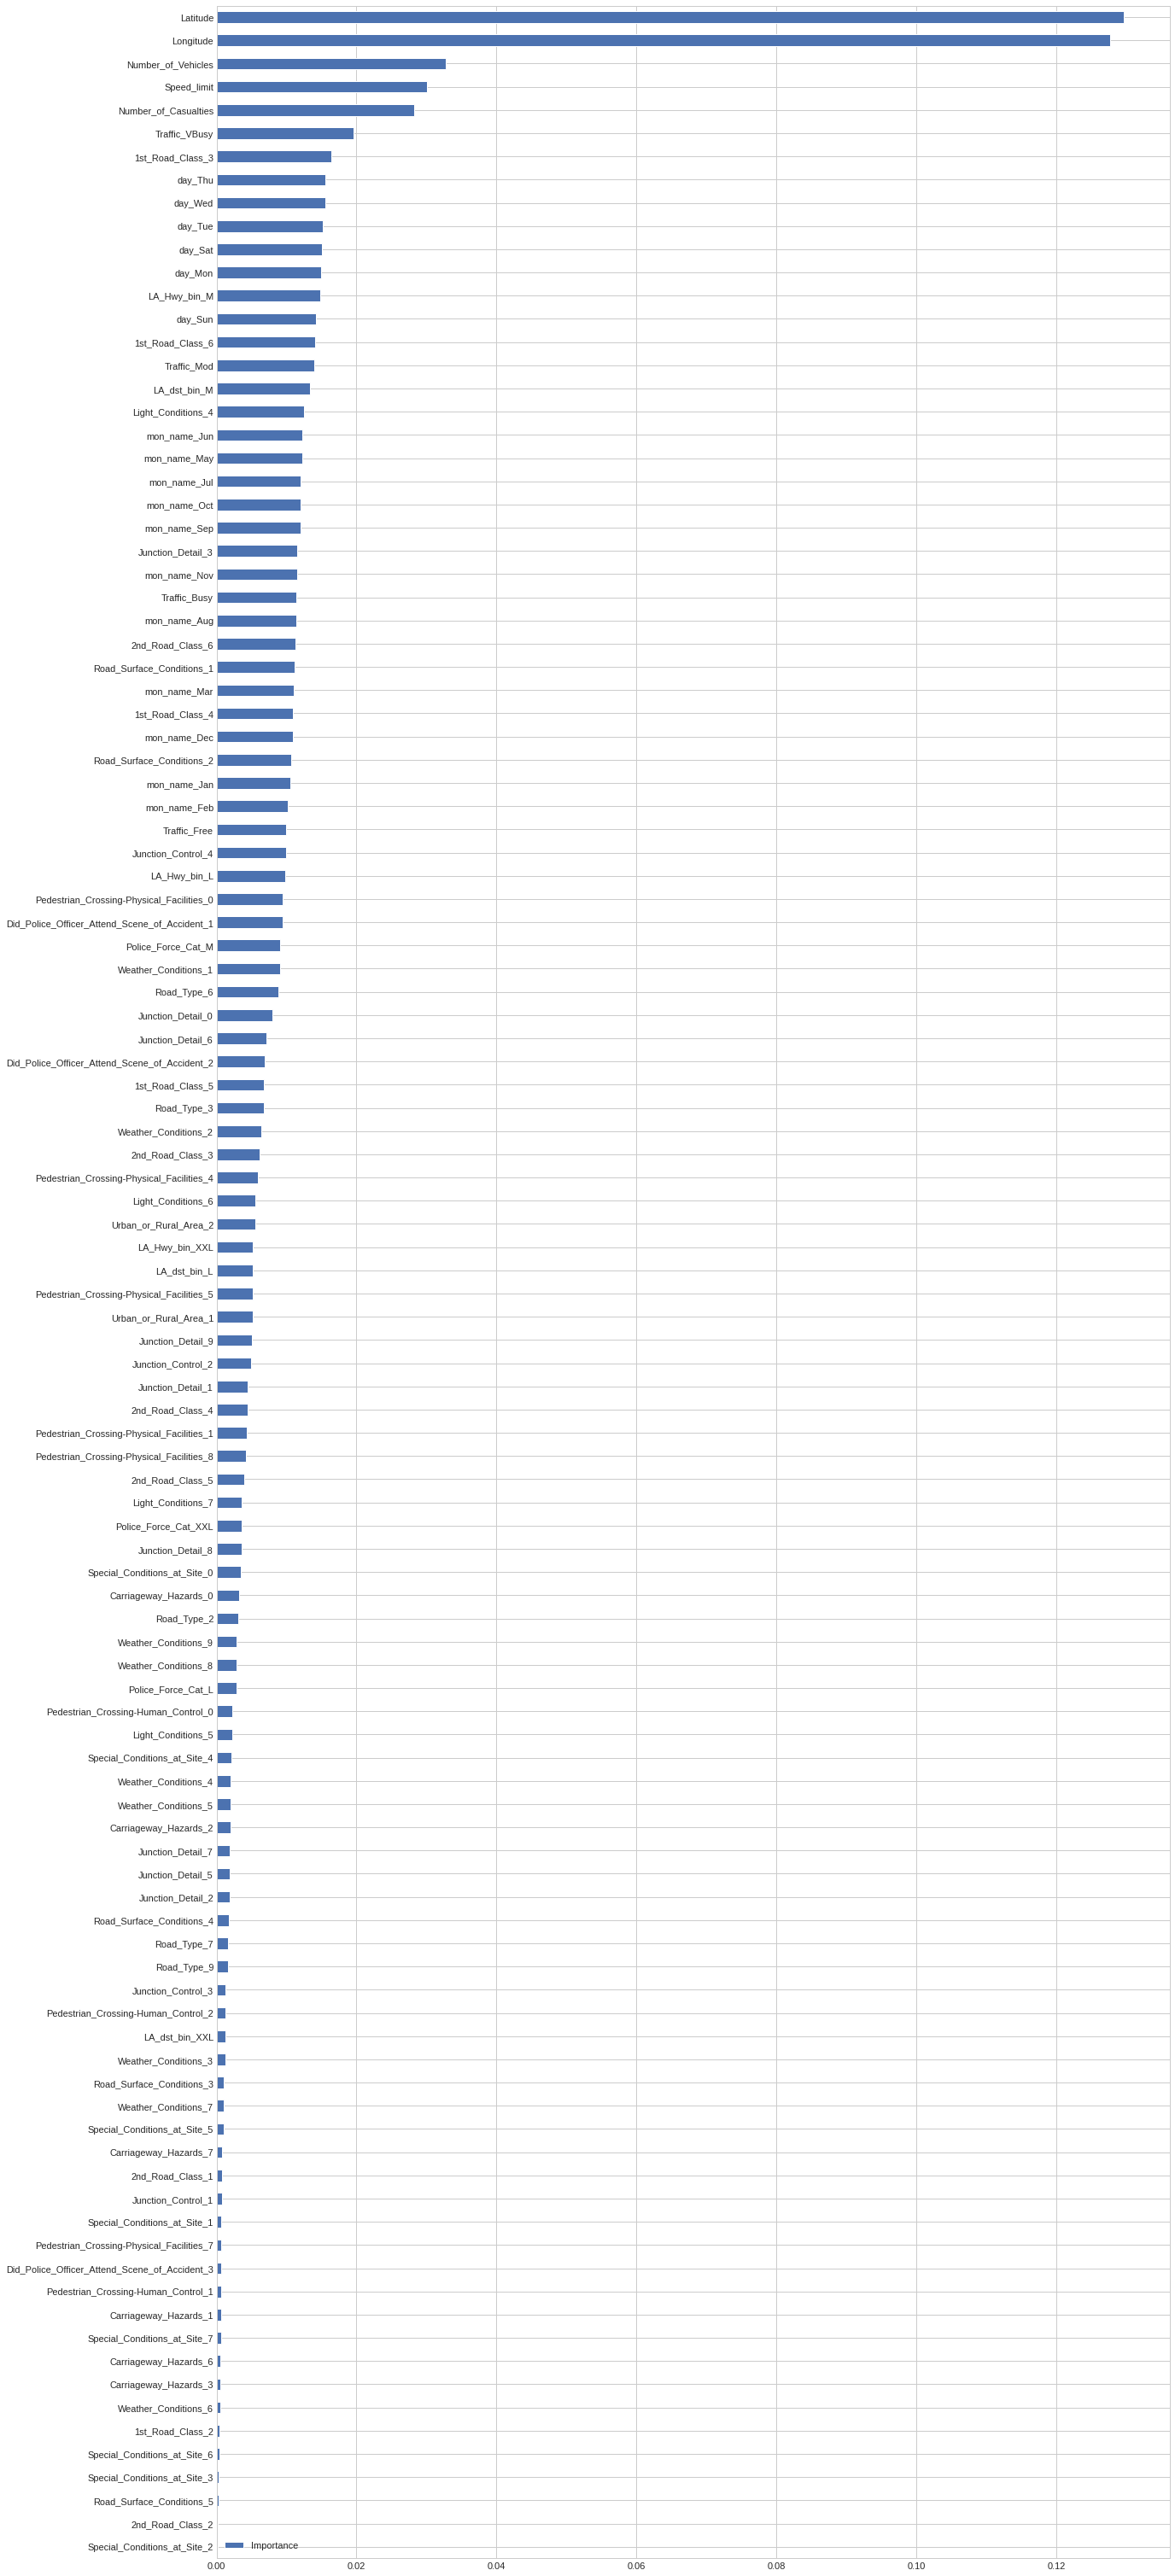

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Using Random Forest to gain an insight on Feature Importance
rfclf = RandomForestClassifier()
rfclf.fit(X_train, y_train)

plt.style.use('seaborn-whitegrid')
importances = rfclf.feature_importances_

#####
std = np.std([tree.feature_importances_ for tree in rfclf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (f + 1, indices[f], importances[indices[f]]))

#####
df_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
df_importances.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importances)/2));

In [123]:
acc_df.dtypes

Longitude                                       float64
Latitude                                        float64
Accident_Severity                              category
Number_of_Vehicles                                int64
Number_of_Casualties                              int64
1st_Road_Class                                 category
Road_Type                                      category
Speed_limit                                       int64
Junction_Detail                                category
Junction_Control                               category
2nd_Road_Class                                 category
Pedestrian_Crossing-Human_Control              category
Pedestrian_Crossing-Physical_Facilities        category
Light_Conditions                               category
Weather_Conditions                             category
Road_Surface_Conditions                        category
Special_Conditions_at_Site                     category
Carriageway_Hazards                            c

In [54]:
!pip install catboost
from catboost import CatBoostClassifier, Pool


     |████████████████████████████████| 65.9MB 67kB/s 


In [53]:
X_cat = acc_df.drop(columns='Accident_Severity')
y_cat = acc_df.Accident_Severity
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.3)
print(X_cat_train.shape, X_cat_test.shape)

(85791, 25) (36768, 25)


In [56]:
seed = 36
catboost = CatBoostClassifier(iterations=50, eval_metric='AUC', learning_rate=1, random_seed=seed)#,bagging_temperature=0.2)
catboost.fit(X_cat_train,y_cat_train, cat_features=cat_cols, use_best_model=True, eval_set=(X_cat_test,y_cat_test), verbose=True )
#catboost.fit(acc_df.drop('Accident_Severity', axis=1), acc_df['Accident_Severity'], cat_features=cat_cols)

0:	test: 0.5293671	best: 0.5293671 (0)	total: 646ms	remaining: 31.7s
1:	test: 0.6397429	best: 0.6397429 (1)	total: 1.2s	remaining: 28.8s
2:	test: 0.6674069	best: 0.6674069 (2)	total: 1.66s	remaining: 26.1s
3:	test: 0.6910215	best: 0.6910215 (3)	total: 2.19s	remaining: 25.3s
4:	test: 0.7081000	best: 0.7081000 (4)	total: 2.66s	remaining: 23.9s
5:	test: 0.7170913	best: 0.7170913 (5)	total: 3.14s	remaining: 23s
6:	test: 0.7215160	best: 0.7215160 (6)	total: 3.6s	remaining: 22.1s
7:	test: 0.7236309	best: 0.7236309 (7)	total: 4.08s	remaining: 21.4s
8:	test: 0.7242557	best: 0.7242557 (8)	total: 4.55s	remaining: 20.7s
9:	test: 0.7253958	best: 0.7253958 (9)	total: 4.91s	remaining: 19.6s
10:	test: 0.7284039	best: 0.7284039 (10)	total: 5.38s	remaining: 19.1s
11:	test: 0.7287447	best: 0.7287447 (11)	total: 5.84s	remaining: 18.5s
12:	test: 0.7271268	best: 0.7287447 (11)	total: 6.29s	remaining: 17.9s
13:	test: 0.7273748	best: 0.7287447 (11)	total: 6.75s	remaining: 17.4s
14:	test: 0.7271010	best: 0.72

In [57]:
vals = catboost.feature_importances_

In [58]:
vals

array([ 7.07502417,  6.82895533, 20.23569499,  4.37716103,  2.1655812 ,
        3.36942781,  8.44154978,  0.        ,  0.60308393,  2.92905244,
        0.        ,  0.        ,  0.        ,  1.19622834,  0.96137967,
        0.        ,  0.        ,  6.07657952, 23.04892419,  0.        ,
        0.        ,  6.07037395,  5.01257595,  0.        ,  1.60840769])

In [59]:
acc = list(acc_df.columns)
acc.remove('Accident_Severity')

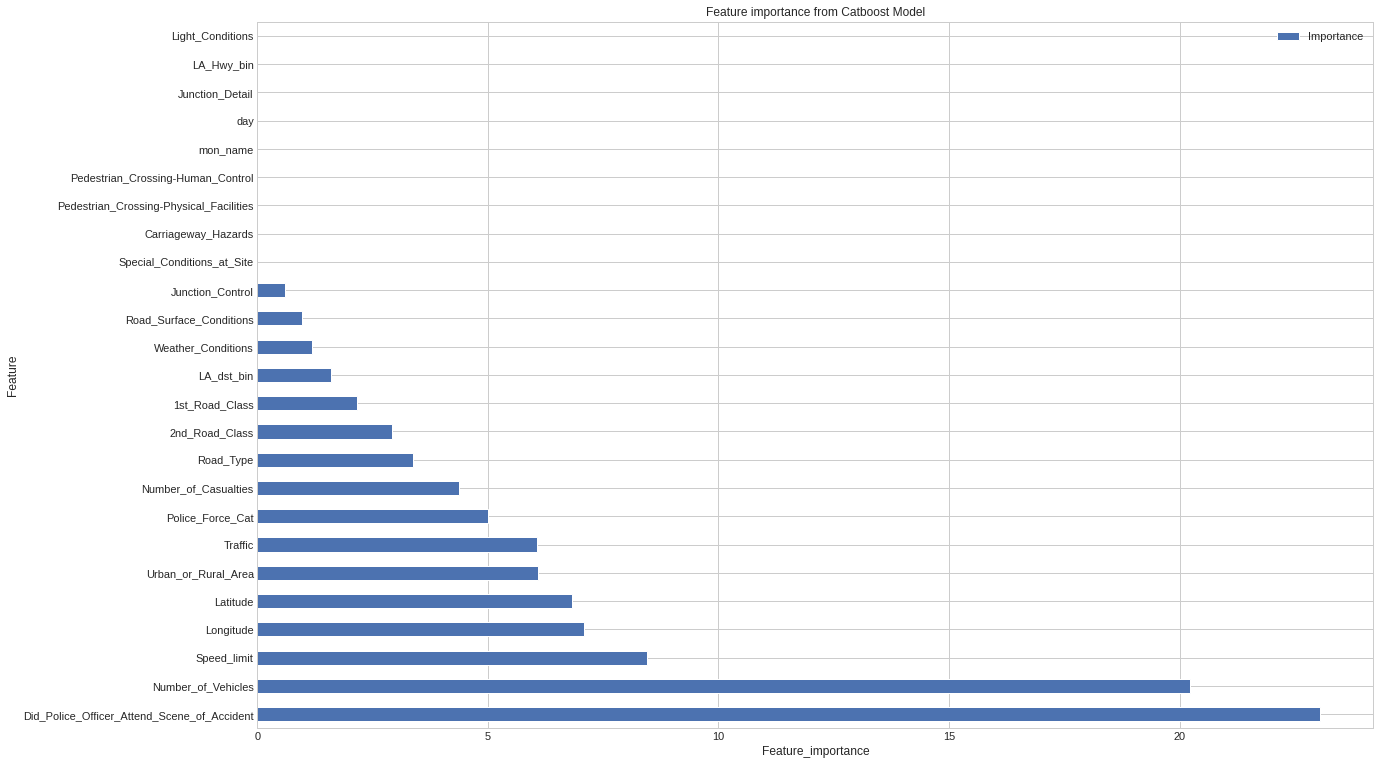

In [60]:
fea_imp = pd.DataFrame(zip(acc,vals), columns=['Feature','Importance']).sort_values('Importance',ascending=False).set_index('Feature')
fea_imp.plot(kind='barh', figsize=(20,13))
plt.xlabel("Feature_importance")
plt.ylabel('Feature')
plt.title('Feature importance from Catboost Model')
plt.show()


In [61]:
fea_imp.head()

,Importance
Feature,
Did_Police_Officer_Attend_Scene_of_Accident,23.048924
Number_of_Vehicles,20.235695
Speed_limit,8.441550
Longitude,7.075024
Latitude,6.828955


## **3.Predictive Modeling**

In [ ]:
# from colab_util import *
# drive_handler = GoogleDriveHandler()


In [62]:
df = X.join(y)
df.to_csv('to_model.csv')

**# 3.1 Preprocessing**

In [63]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# set random_state SEED variable
seed = 36

In [64]:
#X.head()
cont_cols = [col for col in X if X[col].dtype in ['int64','float64']]
cont_cols

['Longitude',
 'Latitude',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Speed_limit']

In [65]:
ss = StandardScaler()
X[cont_cols] = ss.fit_transform(X[cont_cols])
X.head()


,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Speed_limit,1st_Road_Class_2,1st_Road_Class_3,1st_Road_Class_4,1st_Road_Class_5,1st_Road_Class_6,Road_Type_2,Road_Type_3,Road_Type_6,Road_Type_7,Road_Type_9,Junction_Detail_0,Junction_Detail_1,Junction_Detail_2,Junction_Detail_3,Junction_Detail_5,Junction_Detail_6,Junction_Detail_7,Junction_Detail_8,Junction_Detail_9,Junction_Control_1,Junction_Control_2,Junction_Control_3,Junction_Control_4,2nd_Road_Class_1,2nd_Road_Class_2,2nd_Road_Class_3,2nd_Road_Class_4,2nd_Road_Class_5,2nd_Road_Class_6,Pedestrian_Crossing-Human_Control_0,Pedestrian_Crossing-Human_Control_1,Pedestrian_Crossing-Human_Control_2,Pedestrian_Crossing-Physical_Facilities_0,Pedestrian_Crossing-Physical_Facilities_1,Pedestrian_Crossing-Physical_Facilities_4,...,Carriageway_Hazards_1,Carriageway_Hazards_2,Carriageway_Hazards_3,Carriageway_Hazards_6,Carriageway_Hazards_7,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2,Did_Police_Officer_Attend_Scene_of_Accident_1,Did_Police_Officer_Attend_Scene_of_Accident_2,Did_Police_Officer_Attend_Scene_of_Accident_3,mon_name_Aug,mon_name_Dec,mon_name_Feb,mon_name_Jan,mon_name_Jul,mon_name_Jun,mon_name_Mar,mon_name_May,mon_name_Nov,mon_name_Oct,mon_name_Sep,day_Mon,day_Sat,day_Sun,day_Thu,day_Tue,day_Wed,Traffic_Busy,Traffic_Mod,Traffic_VBusy,Traffic_Free,Police_Force_Cat_M,Police_Force_Cat_L,Police_Force_Cat_XXL,LA_Hwy_bin_M,LA_Hwy_bin_L,LA_Hwy_bin_XXL,LA_dst_bin_M,LA_dst_bin_L,LA_dst_bin_XXL
0,0.806204,-0.658766,0.213129,0.904436,-0.504779,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0.939633,-0.647831,-1.173180,-0.405361,-0.504779,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0.832905,-0.655021,0.213129,-0.405361,-1.215458,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0.933439,-0.654707,0.213129,-0.405361,-0.504779,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0.953469,-0.698928,0.213129,0.904436,-0.504779,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [66]:

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = seed)

train_total = len(y_train)
print('Training Set\nTotal:\t\t{}'.format(train_total))

test_total = len(y_test)
print('Test Set\nTotal:\t\t{}'.format(test_total))

Training Set
Total:		85791
Test Set
Total:		36768


**Check for balanced data**

Counter({3: 97744, 2: 23146, 1: 1669})
Class=3, Count=97744, Percentage=79.753%
Class=2, Count=23146, Percentage=18.886%
Class=1, Count=1669, Percentage=1.362%


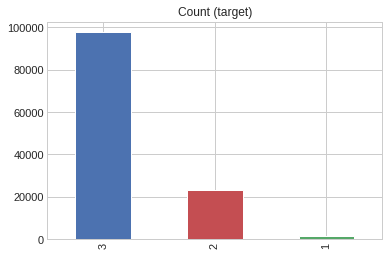

In [71]:
target = acc_df.Accident_Severity.values
counter = Counter(target)
print(counter)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))
target_count = acc_df.Accident_Severity.value_counts()

target_count.plot(kind='bar', title = 'Count (target)', color =['b','r','g'])
plt.show()

This is terribly skewed data. We need to balance it using a SMOTE method. Let us first model to see the accuracy and come back to balancing the dataset.

In [68]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

[(1, 97744), (2, 97744), (3, 97744)]


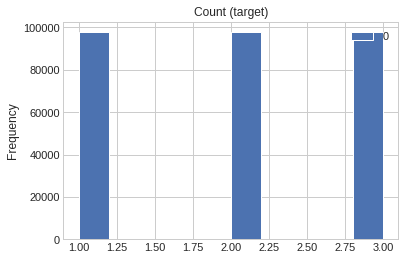

In [80]:
v = pd.DataFrame(y_resampled)
v.plot(kind='hist', title = 'Count (target)', color =['b','r','g'])
plt.show()

In [81]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=seed)
X_res_train.shape, X_res_test.shape

((205262, 110), (87970, 110))

#**Machine Learning Algorithms**
Let's try each of the following models:

1. Logistic Regression

2. KNN

3. SVC

4. Decision Tree

5. Random Forest

6. Gradient Boosted Trees

7. CatBoost



**Logistic Regression**

In [160]:
# Machine learning 
#import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
#tree
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

import time
import datetime

In [199]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

In [83]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [159]:
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

**Logistic regression**

In [170]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 171.35 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.798 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 7.799903127616681e-20, 'class_weight': None, 'C': 2.5341970675601434e+18}

Model with rank: 2
Mean validation score: 0.507 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 4553.714898525413, 'class_weight': 'balanced', 'C': 0.00012752947183557474}

Model with rank: 3
Mean validation score: 0.492 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2.2513097050152566e-16, 'class_weight': 'balanced', 'C': 1798562327.7639174}

Model with rank: 4
Mean validation score: 0.492 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 145584893009.14905, 'class_weight': 'balanced', 'C': 3.648011557884102}

Model with rank: 5
Mean validation score: 0.363 (std: 0.005)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.3970582730290225e-08, 'class_weight': 'balanced', 'C': 1.4

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [208]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_res_train, y_res_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 243.78 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.534 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 0.0001590816775319673, 'class_weight': None, 'C': 75698610672.77132}

Model with rank: 2
Mean validation score: 0.534 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 6.740356517769649e-14, 'class_weight': 'balanced', 'C': 2646319.422130502}

Model with rank: 3
Mean validation score: 0.534 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1403507447427.5757, 'class_weight': 'balanced', 'C': 1.5132754683458236e+19}

Model with rank: 4
Mean validation score: 0.527 (std: 0.001)
Parameters: {'penalty': 'l2', 'intercept_scaling': 634.2788469535163, 'class_weight': None, 'C': 0.001121256491746096}

Model with rank: 5
Mean validation score: 0.473 (std: 0.001)
Parameters: {'penalty': 'l2', 'intercept_scaling': 3.504729187816598e-14, 'class_weight': 'balanced', 'C': 2.865798985321

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [171]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_res_train, 
                                                                 y_res_train, 
                                                                 X_test, y_test,
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 50.29
Accuracy CV 10-Fold: 53.4
Running Time: 0:04:39.785855


In [172]:
print(metrics.classification_report(y_test, test_pred_log))


              precision    recall  f1-score   support

           1       0.04      0.63      0.08       524
           2       0.24      0.35      0.28      6992
           3       0.86      0.54      0.66     29252

    accuracy                           0.50     36768
   macro avg       0.38      0.50      0.34     36768
weighted avg       0.73      0.50      0.58     36768



In [173]:
y_prob = probs_log

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.694209 (macro),
0.686730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.662918 (macro),
0.628706 (weighted by prevalence)


In [210]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 53.23
Accuracy CV 10-Fold: 53.39
Running Time: 0:02:25.815796


In [212]:
print(metrics.classification_report(y_res_train, train_pred_log))


              precision    recall  f1-score   support

           1       0.57      0.68      0.62     68605
           2       0.45      0.39      0.41     68469
           3       0.57      0.54      0.55     68188

    accuracy                           0.53    205262
   macro avg       0.53      0.53      0.53    205262
weighted avg       0.53      0.53      0.53    205262



In [ ]:
print(metrics.classification_report(y_test, test_pred_log))


              precision    recall  f1-score   support

           1       1.00      0.00      0.01       524
           2       0.47      0.00      0.00      6992
           3       0.80      1.00      0.89     29252

    accuracy                           0.80     36768
   macro avg       0.76      0.34      0.30     36768
weighted avg       0.74      0.80      0.71     36768



**K-Nearest Neighbors**

In [1]:
# # k-Nearest Neighbors
# start_time = time.time()
# train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
#                                                                                                  algorithm = 'brute',
#                                                                                                  n_jobs = -1), 
#                                                                                                  X_res_train, 
#                                                                                                  y_res_train, 
#                                                                                                  X_test, y_test,
#                                                                                                  10)
# knn_time = (time.time() - start_time)
# print("Accuracy: %s" % acc_knn)
# print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
# print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

In [ ]:
print(metrics.classification_report(y_train, train_pred_knn))


In [ ]:
print(metrics.classification_report(y_test, test_pred_knn))


In [ ]:
y_prob = probs_knn
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

**Gaussian Naive Bayes**

In [162]:
#Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_res_train, 
                                                                                     y_res_train, 
                                                                                     X_test, y_test,
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 24.9
Accuracy CV 10-Fold: 43.09
Running Time: 0:00:03.813434


In [164]:
print(metrics.classification_report(y_res_train, train_pred_gaussian))


              precision    recall  f1-score   support

           1       0.41      0.87      0.56     68605
           2       0.38      0.17      0.23     68469
           3       0.57      0.26      0.35     68188

    accuracy                           0.43    205262
   macro avg       0.45      0.43      0.38    205262
weighted avg       0.45      0.43      0.38    205262



In [165]:
print(metrics.classification_report(y_test, test_pred_gaussian))


              precision    recall  f1-score   support

           1       0.02      0.79      0.04       524
           2       0.17      0.17      0.17      6992
           3       0.85      0.26      0.40     29252

    accuracy                           0.25     36768
   macro avg       0.34      0.41      0.20     36768
weighted avg       0.71      0.25      0.35     36768



In [167]:
y_prob = probs_gau

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                      average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                   average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
       "(weighted by prevalence)"
       .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
       "(weighted by prevalence)"
       .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.621472 (macro),
0.610608 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.588385 (macro),
0.569537 (weighted by prevalence)


**Linear SVC**

In [137]:
# # Linear SVC
# start_time = time.time()
# train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(max_iter=1000),
#                                                                                            X_res_train, 
#                                                                                            y_res_train,
#                                                                                            X_test, y_test,
#                                                                                            10)
# linear_svc_time = (time.time() - start_time)
# print("Accuracy: %s" % acc_linear_svc)
# print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
# print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

In [139]:
svc =LinearSVC(multi_class='ovr')
svc.fit(X_res_train,y_res_train)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [144]:
test_pred_svc = svc.predict(X_test)
train_pred_svc = svc.predict(X_res_train)

In [169]:
print(metrics.classification_report(y_res_train, train_pred_svc))


              precision    recall  f1-score   support

           1       0.56      0.71      0.63     68605
           2       0.45      0.34      0.39     68469
           3       0.56      0.55      0.55     68188

    accuracy                           0.53    205262
   macro avg       0.52      0.53      0.52    205262
weighted avg       0.52      0.53      0.52    205262



In [145]:
print(metrics.classification_report(y_test, test_pred_svc))


              precision    recall  f1-score   support

           1       0.04      0.66      0.07       524
           2       0.24      0.31      0.27      6992
           3       0.86      0.55      0.67     29252

    accuracy                           0.50     36768
   macro avg       0.38      0.51      0.34     36768
weighted avg       0.73      0.50      0.58     36768



In [146]:
print(metrics.classification_report(y_res_train, train_pred_svc))


              precision    recall  f1-score   support

           1       0.56      0.71      0.63     68605
           2       0.45      0.34      0.39     68469
           3       0.56      0.55      0.55     68188

    accuracy                           0.53    205262
   macro avg       0.52      0.53      0.52    205262
weighted avg       0.52      0.53      0.52    205262



In [147]:
acc_svc = round(svc.score(X_test, y_test) * 100, 2) 
acc_svc


50.38

In [152]:
 # CV 
train_pred = model_selection.cross_val_predict(LinearSVC(multi_class='ovr'), 
                                                  X_res_train, 
                                                  y_res_train, 
                                                  cv=10, 
                                                  n_jobs = -1)
svc_acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

KeyboardInterrupt: ignored

In [ ]:
print(metrics.classification_report(y_test, test_pred_svc))


**Stochastic Gradient Descent** 

In [155]:
#Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_res_train, 
                                                                 y_res_train, 
                                                                 X_test, y_test,
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 50.89
Accuracy CV 10-Fold: 50.51
Running Time: 0:01:05.495354


In [157]:
print(metrics.classification_report(y_res_train, train_pred_sgd))


              precision    recall  f1-score   support

           1       0.51      0.78      0.62     68605
           2       0.46      0.10      0.16     68469
           3       0.50      0.63      0.56     68188

    accuracy                           0.51    205262
   macro avg       0.49      0.51      0.45    205262
weighted avg       0.49      0.51      0.45    205262



In [158]:
print(metrics.classification_report(y_test, test_pred_sgd))


              precision    recall  f1-score   support

           1       0.03      0.76      0.06       524
           2       0.24      0.12      0.16      6992
           3       0.85      0.60      0.70     29252

    accuracy                           0.51     36768
   macro avg       0.37      0.49      0.31     36768
weighted avg       0.72      0.51      0.59     36768



**Decision Tree Classifier**

In [124]:
# Decision Tree Classifier
start_time = time.time()

def fit_ml_algo_clf(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs, model

train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt, clf_obj = fit_ml_algo_clf(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, y_test,
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 68.02
Accuracy CV 10-Fold: 68.4
Running Time: 0:00:21.763870


In [125]:
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt, clf_obj = fit_ml_algo_clf(DecisionTreeClassifier(), 
                                                             X_res_train, 
                                                             y_res_train, 
                                                             X_test, y_test,
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 88.4
Accuracy CV 10-Fold: 82.75
Running Time: 0:01:39.216225


In [127]:
print(metrics.classification_report(y_test, test_pred_dt))


              precision    recall  f1-score   support

           1       0.65      0.74      0.69       524
           2       0.69      0.77      0.73      6992
           3       0.94      0.91      0.93     29252

    accuracy                           0.88     36768
   macro avg       0.76      0.81      0.78     36768
weighted avg       0.89      0.88      0.89     36768



In [129]:
print(metrics.classification_report(y_res_train, train_pred_dt))


              precision    recall  f1-score   support

           1       0.93      0.96      0.95     68605
           2       0.76      0.75      0.76     68469
           3       0.79      0.77      0.78     68188

    accuracy                           0.83    205262
   macro avg       0.83      0.83      0.83    205262
weighted avg       0.83      0.83      0.83    205262



In [101]:
print(metrics.classification_report(y_test, test_pred_dt))


              precision    recall  f1-score   support

           1       0.67      0.74      0.70       524
           2       0.69      0.77      0.73      6992
           3       0.94      0.91      0.93     29252

    accuracy                           0.88     36768
   macro avg       0.77      0.81      0.79     36768
weighted avg       0.89      0.88      0.89     36768



In [131]:

y_prob = clf_obj.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                      average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                   average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
       "(weighted by prevalence)"
       .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
       "(weighted by prevalence)"
       .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.855116 (macro),
0.853177 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.851648 (macro),
0.844711 (weighted by prevalence)


In [109]:
# #plot_roc_curve(y_test, probs_dt)
# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# plt.show()

**Random Forest Classifier**

In [110]:

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 49.14 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.799 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 7, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.798 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.798 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.798 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 10, 'min_samples_split': 15}

Model with rank: 3
Mean validation score: 0.798 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', '

In [111]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, y_test,
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 79.41
Accuracy CV 10-Fold: 79.77
Running Time: 0:00:16.521545


In [112]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_res_train, 
                                                             y_res_train, 
                                                             X_test, y_test,
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 83.28
Accuracy CV 10-Fold: 87.75
Running Time: 0:00:46.254069


In [118]:
print(metrics.classification_report(y_test, test_pred_rf))


              precision    recall  f1-score   support

           1       0.69      0.47      0.56       524
           2       0.62      0.43      0.51      6992
           3       0.87      0.94      0.90     29252

    accuracy                           0.83     36768
   macro avg       0.73      0.61      0.66     36768
weighted avg       0.82      0.83      0.82     36768



In [117]:
print(metrics.classification_report(y_res_train, train_pred_rf))


              precision    recall  f1-score   support

           1       0.95      0.98      0.96     68605
           2       0.88      0.76      0.81     68469
           3       0.81      0.90      0.85     68188

    accuracy                           0.88    205262
   macro avg       0.88      0.88      0.88    205262
weighted avg       0.88      0.88      0.88    205262



In [120]:
rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=17,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [121]:
#plot_roc_curve(y_test, probs_rf)

y_prob = rfc.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                      average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                   average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
       "(weighted by prevalence)"
       .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
       "(weighted by prevalence)"
       .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.898821 (macro),
0.886790 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.878471 (macro),
0.827416 (weighted by prevalence)


**Gradient Boosting Trees**

In [123]:

# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,                                                                            
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

KeyboardInterrupt: ignored

In [ ]:
print(metrics.classification_report(y_train, train_pred_gbt))


In [ ]:
print(metrics.classification_report(y_test, test_pred_gbt))


In [ ]:

# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,                                                                            
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

In [ ]:
plot_roc_curve(y_test, probs_gbt)


**CatBoost Classifier**

     |████████████████████████████████| 65.9MB 59kB/s 


(85796, 29) (36771, 29)


In [45]:
cat_cols

['Accident_Index',
 'Police_Force',
 'Accident_Severity',
 'Date',
 'Time',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident']

In [41]:
y_cat_train.shape

(85796,)

In [48]:
y_cat.dtypes

CategoricalDtype(categories=[1, 2, 3], ordered=False)

In [125]:
X_cat = acc_df.drop(columns='Accident_Severity')
y_cat = acc_df.Accident_Severity
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.3)
print(X_cat_train.shape, X_cat_test.shape)

(85791, 25) (36768, 25)


In [46]:
catboost = CatBoostClassifier(iterations=50) #eval_metric='AUC')#learning_rate=1, eval_metric='AUC')#iterations=100)# eval_metric='Accuracy', random_seed=36)#,bagging_temperature=0.2)
catboost.fit(X_cat_train,y_cat_train, cat_features=cat_cols, use_best_model=True, eval_set=(X_cat_test,y_cat_test), verbose=True )
#catboost.fit(X_cat, y_cat, cat_features=cat_cols)

ValueError: ignored

In [ ]:
feat_imp = catboost.feature_importances_


In [ ]:
feat_imp

array([10.64804145, 10.39335099, 11.08734236,  3.83513962,  5.19791165,
        2.77422954,  7.1509845 ,  3.65157288,  1.45179438,  1.51658782,
        0.18718548,  0.93262336,  4.20672221,  1.05746314,  3.68859412,
        0.49810212,  0.07308346,  3.43313755, 14.926303  ,  0.14551881,
        0.26884305,  4.80513261,  5.30257113,  2.2532117 ,  0.51455308])

In [ ]:
catboost.get_params()

{'iterations': 100}

In [ ]:
print(metrics.classification_report(y_cat_test,catboost.predict(X_cat_test)))

              precision    recall  f1-score   support

           1       1.00      0.00      0.00       500
           2       0.42      0.01      0.02      6982
           3       0.80      1.00      0.89     29286

    accuracy                           0.80     36768
   macro avg       0.74      0.34      0.30     36768
weighted avg       0.73      0.80      0.71     36768



In [ ]:
catboost.get_best_score()

{'learn': {'MultiClass': 0.5067229222705147},
 'validation': {'MultiClass': 0.518783541982016}}

In [ ]:
catboost.score(X_cat_train,y_cat_train)

0.7993728945926729

In [ ]:
catboost.score(X_cat_test,y_cat_test)

0.7964262402088773

## **Results**

**Without CV**

In [ ]:

models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Stochastic Gradient Decent', 
              'Linear SVC', 'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
models.sort_values(by='Accuracy', ascending=False)

**10-Fold CV**

In [ ]:

models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees','Cat Boost'],
    'Accuracy (10-fold CV)': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
models.sort_values(by='Accuracy (10-fold CV)', ascending=False)

In [ ]:
# dfs = [veh_df, cas_df]
# df_veh_cas = reduce(lambda left,right: pd.merge(left,right,on=['Accident_Index','Vehicle_Reference']), dfs)
# df_final = reduce(lambda left,right: pd.merge(left,right,on=['Accident_Index']), [acc_df, df_veh_cas])

In [ ]:
# print("The merged vehicle and casualty dataframe's dimension is", df_veh_cas.shape)
# print("The merged dataframe's dimension is", df_final.shape)

In [ ]:
# df_final.duplicated().any()

In [ ]:
# df_final = df_final[df_final.Accident_Severity == df_final.Casualty_Severity]
# df_final.shape

In [ ]:
# cols = list(df_final.columns.values) #Make a list of all of the columns in the df
# cols.pop(cols.index('Casualty_Severity')) #Remove b from list
# #cols.pop(cols.index('x')) #Remove x from list
# df_final = df_final[cols+['Casualty_Severity']] #Create new dataframe with columns in the order you want

The final Dataframe looks like the follows:

In [138]:
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# corrMatrix = pd.concat([X,y], axis=1).corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()
#ONE MUST USE CRAMER'S V for CATEGORICAL CORR and CORR_MATRiX for numerical features ( OR USE ETA FOR MIXED USAGE CORRELATION)

Since there are too many features and it is hard to find correlation from a corr plot, we must instead try to model this and find the feature importance to select the impactful features.

In [ ]:
rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           #criterion = 'entropy',
                           random_state = 42)
rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), \
                                                                                             rf.oob_score_,\
                                                                                             rf.score(X_valid, y_valid)))


R^2 Training Score: 1.00 
OOB Score: 0.84 
R^2 Validation Score: 0.84


We know from the above data visualizations that 'Slight' Accidents are the most and hence the dataset is highly imbalanced/skewed. We would hence want to balance them by using SMOTE.


**Evaulating the Model**

In [ ]:
confusion_matrix(rf.predict(X_valid), y_valid )

array([[   22,    20,     8],
       [  109,   793,   668],
       [  394,  6911, 39226]])

In [ ]:
classification_report(y_valid, rf.predict(X_valid), target_names=['Fatal', 'Severity', 'Serious'])

'              precision    recall  f1-score   support\n\n       Fatal       0.44      0.04      0.08       525\n    Severity       0.51      0.10      0.17      7724\n     Serious       0.84      0.98      0.91     39902\n\n    accuracy                           0.83     48151\n   macro avg       0.60      0.38      0.38     48151\nweighted avg       0.78      0.83      0.78     48151\n'

In [ ]:
#new scki-kit look up 
#def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
#   lb = LabelBinarizer()
#   lb.fit(y_test)
#   y_test = lb.transform(y_test)
#   y_pred = lb.transform(y_pred)
#   return roc_auc_score(y_test, y_pred, average=average)

# roc_auc_score(y_valid, rf.predict(X_valid))

In [ ]:
df_final['predicted'] = rf.predict(X)
df_final.head(5)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Month,mon_name,hour,day,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_Band_of_Casualty,Pedestrian_Location,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_Severity,predicted
0,2018010080971,529150.0,182270.0,-0.139737,51.524587,1,3,2,2,2018-01-01,2,2020-07-27 01:30:00,2,98,3,501,3,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,1,January,1,Mon,1,9,0,18,0,0,0,0,0,0,1,1,6,1,6,1995,2,5,8,1,1,2,2,8,0,2,0,0,9,1,3,3
1,2018010080971,529150.0,182270.0,-0.139737,51.524587,1,3,2,2,2018-01-01,2,2020-07-27 01:30:00,2,98,3,501,3,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,1,January,1,Mon,2,8,0,18,0,0,0,0,0,0,2,1,6,1,8,1798,8,6,1,1,2,1,1,8,0,0,0,0,8,1,3,3
2,2018010080973,542020.0,184290.0,0.046471,51.539651,1,3,1,1,2018-01-01,2,2020-07-27 00:50:00,17,116,4,165,6,30,2,4,6,0,0,0,4,1,1,0,0,1,1,1,January,0,Mon,1,9,0,18,0,2,0,0,0,0,1,1,6,3,-1,-1,-1,-1,-1,-1,1,3,1,6,5,0,0,2,0,1,3,3
3,2018010080974,531720.0,182910.0,-0.102474,51.529746,1,3,2,1,2018-01-01,2,2020-07-27 00:45:00,3,110,3,1,6,20,6,4,5,0,0,5,4,1,1,0,0,1,1,1,January,0,Mon,1,8,0,7,0,8,0,0,0,0,1,1,1,1,7,1797,8,6,3,1,1,1,1,7,0,0,0,0,8,1,3,3
4,2018010080981,541450.0,183220.0,0.037828,51.530179,1,2,2,1,2018-01-01,2,2020-07-27 03:00:00,17,116,4,167,3,30,7,2,3,124,0,5,4,2,2,0,0,1,1,1,January,3,Mon,1,9,0,9,0,1,0,0,0,0,1,1,6,1,6,1200,1,1,7,1,1,1,1,6,0,0,0,0,9,1,2,3


In [ ]:
feature_importance = rf.feature_importances_
feature_importance

array([0.05002703, 0.05093743, 0.04950109, 0.05098668, 0.02731148,
       0.01540611, 0.01484649, 0.02780639, 0.0433997 , 0.01402884,
       0.03636419, 0.01068212, 0.01781256, 0.01505385, 0.00777998,
       0.0097475 , 0.01183169, 0.00169899, 0.00993725, 0.01187111,
       0.01043794, 0.00981091, 0.00324211, 0.00262433, 0.00681395,
       0.01033326, 0.03427961, 0.04229484, 0.02299268, 0.00132681,
       0.02565016, 0.00439769, 0.01396475, 0.01115238, 0.0068427 ,
       0.01308954, 0.00950429, 0.01831215, 0.00111999, 0.01445331,
       0.00744075, 0.02640463, 0.03954318, 0.00975678, 0.03167718,
       0.02936349, 0.01150163, 0.00676607, 0.00814978, 0.00710937,
       0.03042038, 0.01016976, 0.00374107, 0.00072142, 0.00127358,
       0.0244745 , 0.01181253])

In [ ]:
imp_columns = feature_importance >0.01
imp_columns
                   

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True,  True, False,  True, False,  True,  True, False,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True, False, False,
       False,  True,  True])

In [ ]:
X_train = X_train[X_train.columns[imp_columns]]
X_valid = X_valid[X_valid.columns[imp_columns]]

In [ ]:
print(X_train.shape)
print(X_valid.shape)

(106655, 36)
(45710, 36)


The following are the features considered 


In [ ]:
X[X.columns[imp_columns]].columns

Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Police_Force', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', '2nd_Road_Number', 'Light_Conditions',
       'Weather_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Month', 'hour', 'Vehicle_Type', 'Vehicle_Manoeuvre',
       'Junction_Location', 'Skidding_and_Overturning',
       'Vehicle_Leaving_Carriageway', '1st_Point_of_Impact',
       'Journey_Purpose_of_Driver', 'Age_Band_of_Driver',
       'Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Driver_IMD_Decile',
       'Driver_Home_Area_Type', 'Age_Band_of_Casualty', 'Pedestrian_Location',
       'Casualty_Type', 'Casualty_Home_Area_Type'],
      dtype='object')

The following are the ignored features

In [ ]:
not_imp_cols = X[X.columns[~imp_columns]].columns
not_imp_cols

Index(['Junction_Control', '2nd_Road_Class',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Towing_and_Articulation',
       'Vehicle_Location-Restricted_Lane', 'Hit_Object_in_Carriageway',
       'Hit_Object_off_Carriageway', 'Was_Vehicle_Left_Hand_Drive?',
       'Sex_of_Driver', 'Propulsion_Code', 'Casualty_Reference',
       'Casualty_Class', 'Sex_of_Casualty', 'Car_Passenger',
       'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker'],
      dtype='object')

In [ ]:
#!pip install pycaret


In [ ]:
from pycaret.classification import *

ModuleNotFoundError: ignored

In [ ]:
test_df = acc_df.copy()

In [ ]:
test_df.Accident_Severity.replace(to_replace=3, value=2, inplace=True)

In [ ]:
test_df.Accident_Severity.value_counts()

2    120898
1      1669
Name: Accident_Severity, dtype: int64

In [ ]:
exp_clf = setup(test_df.head(1000), target='Accident_Severity')


 
Setup Succesfully Completed!


,Description,Value
0,session_id,1562
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(1000, 35)"
4,Missing Values,False
5,Numeric Features,10
6,Categorical Features,22
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,K Neighbors Classifier,0.995700,0.149300,0.000000,0.000000,0.000000,nan
1,SVM - Linear Kernel,0.995700,0.000000,0.000000,0.000000,0.000000,nan
2,Ridge Classifier,0.995700,0.000000,0.000000,0.000000,0.000000,nan
3,Random Forest Classifier,0.995700,0.144200,0.000000,0.000000,0.000000,nan
4,Quadratic Discriminant Analysis,0.995700,0.150000,0.000000,0.000000,0.000000,nan
5,Extra Trees Classifier,0.995700,0.182600,0.000000,0.000000,0.000000,nan
6,Extreme Gradient Boosting,0.995700,0.147800,0.000000,0.000000,0.000000,nan
7,CatBoost Classifier,0.995700,0.131900,0.000000,0.000000,0.000000,nan
8,Light Gradient Boosting Machine,0.994300,0.160900,0.000000,0.000000,0.000000,nan
9,Ada Boost Classifier,0.991400,0.121000,0.000000,0.000000,0.000000,nan


Let us use Pycaret to fit and evaluate on different models. 


the following function - compare_models -  uses all models in the model library and scores them using Stratified Cross Validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold (default CV = 10 Folds) of all the available models in the model library.



Result: The function returns a score grid that specifies the best models for each of the performance metrics.
The performance metrics used for classification are Accuracy, AUC, Recall, Precision, F1, Kappa.

In [ ]:
create_model('knn', fold = 7, round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.82,0.0,0.48,0.72,0.77,-0.05
1,0.83,0.0,0.49,0.72,0.77,-0.04
2,0.85,0.0,0.50,0.72,0.78,0.00
3,0.84,0.0,0.33,0.72,0.78,-0.02
4,0.85,0.0,0.35,0.80,0.80,0.09
5,0.85,0.0,0.33,0.72,0.78,0.00
6,0.84,0.0,0.49,0.73,0.78,-0.04
Mean,0.84,0.0,0.42,0.73,0.78,-0.01
SD,0.01,0.0,0.08,0.03,0.01,0.04


OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform'),
                    n_jobs=None)

**Tune the Model**

In [ ]:
tuned_rf = tune_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.0,0.5000,0.7347,0.7912,0.0
1,0.8571,0.0,0.5000,0.7347,0.7912,0.0
2,0.8571,0.0,0.5000,0.7347,0.7912,0.0
3,0.8571,0.0,0.5000,0.7347,0.7912,0.0
4,0.8571,0.0,0.5000,0.7347,0.7912,0.0
5,0.8429,0.0,0.5000,0.7104,0.7710,0.0
6,0.8429,0.0,0.3333,0.7104,0.7710,0.0
7,0.8429,0.0,0.3333,0.7104,0.7710,0.0
8,0.8429,0.0,0.3333,0.7104,0.7710,0.0
9,0.8551,0.0,0.5000,0.7311,0.7883,0.0


In [ ]:
print(tuned_rf)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=30,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0,
                                            

In [ ]:
tuned_nb = tune_model('nb')


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8429,0.0,0.4917,0.7329,0.7841,-0.0267
1,0.8429,0.0,0.4917,0.7329,0.7841,-0.0267
2,0.8286,0.0,0.4833,0.7311,0.7768,-0.0500
3,0.8429,0.0,0.4917,0.7329,0.7841,-0.0267
4,0.8571,0.0,0.5000,0.7347,0.7912,0.0000
5,0.8143,0.0,0.4831,0.7065,0.7566,-0.0508
6,0.8286,0.0,0.3554,0.7647,0.7846,0.0840
7,0.8429,0.0,0.3333,0.7104,0.7710,0.0000
8,0.8429,0.0,0.3333,0.7104,0.7710,0.0000
9,0.8116,0.0,0.5161,0.7638,0.7840,0.0406


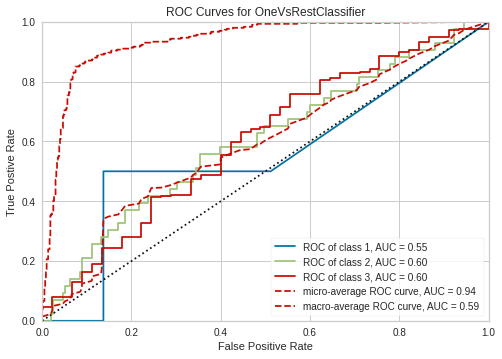

In [ ]:
plot_model(tuned_rf, plot = 'auc')


## **Precision-Recall Curve**

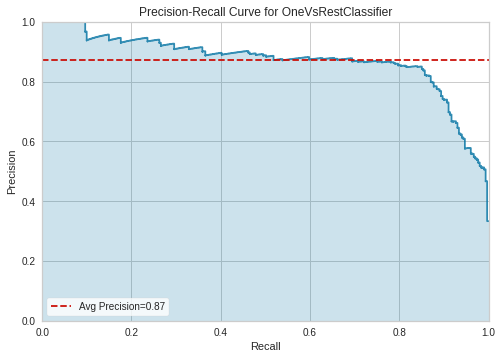

In [ ]:
plot_model(tuned_rf, plot = 'pr')


## **Feature Importance Plot**

In [ ]:
plot_model(tuned_rf, plot='feature')

SystemExit: ignored

# **Confusion Matrix**

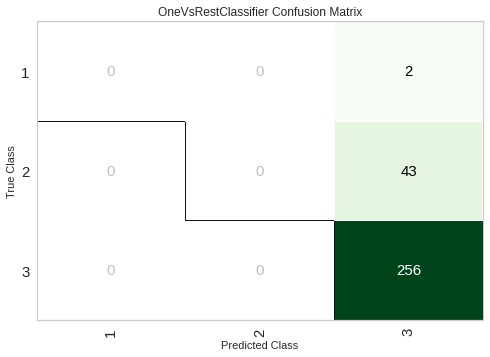

In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')


## **Ensembling**

In [ ]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8000,0.0,0.4667,0.7273,0.7619,-0.0889
1,0.8143,0.0,0.5167,0.7670,0.7870,0.0421
2,0.7429,0.0,0.4333,0.7189,0.7307,-0.1455
3,0.8000,0.0,0.5083,0.7604,0.7782,0.0200
4,0.8571,0.0,0.3611,0.8262,0.8202,0.1860
5,0.7286,0.0,0.4692,0.7181,0.7232,-0.0640
6,0.7857,0.0,0.3661,0.7562,0.7701,0.0964
7,0.7571,0.0,0.3271,0.7248,0.7403,-0.0241
8,0.7857,0.0,0.3661,0.7562,0.7701,0.0964
9,0.7971,0.0,0.5076,0.7571,0.7751,0.0183


# **Bagging**

In [ ]:
bagged_dt = ensemble_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8714,0.0,0.5500,0.8882,0.8233,0.1600
1,0.8714,0.0,0.5500,0.8882,0.8233,0.1600
2,0.8429,0.0,0.4917,0.7329,0.7841,-0.0267
3,0.8286,0.0,0.4833,0.7311,0.7768,-0.0500
4,0.8571,0.0,0.5000,0.7347,0.7912,0.0000
5,0.8286,0.0,0.4915,0.7085,0.7638,-0.0269
6,0.8286,0.0,0.3277,0.7085,0.7638,-0.0256
7,0.8286,0.0,0.3277,0.7085,0.7638,-0.0256
8,0.8143,0.0,0.3220,0.7065,0.7566,-0.0484
9,0.8551,0.0,0.5000,0.7311,0.7883,0.0000


In [ ]:
print(bagged_dt)

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                                              

# **Boosting**

In [ ]:
boosted_dt = ensemble_model(dt, method = 'Boosting', n_estimators=50)


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8143,0.0,0.4750,0.7292,0.7694,-0.0706
1,0.7857,0.0,0.5000,0.7551,0.7694,0.0000
2,0.7714,0.0,0.4917,0.7506,0.7606,-0.0182
3,0.8000,0.0,0.5083,0.7604,0.7782,0.0200
4,0.8429,0.0,0.5333,0.7896,0.8049,0.0941
5,0.7857,0.0,0.5031,0.7374,0.7586,0.0076
6,0.7857,0.0,0.3384,0.7350,0.7579,0.0132
7,0.8000,0.0,0.3718,0.7633,0.7797,0.1195
8,0.8143,0.0,0.3774,0.7719,0.7895,0.1447
9,0.7971,0.0,0.5492,0.7792,0.7875,0.1072


In [ ]:
tuned_bagged_dt = tune_model('dt', ensemble=True, method='Bagging')


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.0,0.5000,0.7347,0.7912,0.0
1,0.8571,0.0,0.5000,0.7347,0.7912,0.0
2,0.8571,0.0,0.5000,0.7347,0.7912,0.0
3,0.8571,0.0,0.5000,0.7347,0.7912,0.0
4,0.8571,0.0,0.5000,0.7347,0.7912,0.0
5,0.8429,0.0,0.5000,0.7104,0.7710,0.0
6,0.8429,0.0,0.3333,0.7104,0.7710,0.0
7,0.8429,0.0,0.3333,0.7104,0.7710,0.0
8,0.8429,0.0,0.3333,0.7104,0.7710,0.0
9,0.8551,0.0,0.5000,0.7311,0.7883,0.0


In [ ]:
print(tuned_bagged_dt)

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=28,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=3,
                                                

# **Blending**

In [ ]:
blend_hard = blend_models()


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.0,0.5000,0.7347,0.7912,0.000
1,0.8714,0.0,0.5500,0.8882,0.8233,0.160
2,0.8571,0.0,0.5000,0.7347,0.7912,0.000
3,0.8571,0.0,0.5000,0.7347,0.7912,0.000
4,0.8571,0.0,0.5000,0.7347,0.7912,0.000
5,0.8429,0.0,0.5000,0.7104,0.7710,0.000
6,0.8429,0.0,0.3333,0.7104,0.7710,0.000
7,0.8429,0.0,0.3333,0.7104,0.7710,0.000
8,0.8429,0.0,0.3333,0.7104,0.7710,0.000
9,0.8551,0.0,0.5000,0.7311,0.7883,0.000


In [ ]:

"""
we will create 4 specific models to be passed into blend_models().
Note that verbose is set to False to avoid printing the score grid of individual models.
"""

gbc = create_model('gbc', verbose = False)
dt = create_model('dt', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)
xgboost = create_model('xgboost', verbose = False)


In [ ]:
blend_specific_soft = blend_models(estimator_list = [gbc,dt, lightgbm, xgboost], method = 'soft')


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8429,0.0,0.3278,0.7329,0.7841,-0.0132
1,0.8286,0.0,0.3222,0.7311,0.7768,-0.0370
2,0.8000,0.0,0.3111,0.7273,0.7619,-0.0538
3,0.7857,0.0,0.3333,0.7823,0.7746,0.0367
4,0.7571,0.0,0.2944,0.7327,0.7447,-0.0085
5,0.7857,0.0,0.3107,0.7243,0.7538,0.0566
6,0.6857,0.0,0.2712,0.6975,0.6916,-0.0635
7,0.7286,0.0,0.2881,0.7047,0.7164,-0.0440
8,0.7286,0.0,0.2881,0.6933,0.7105,-0.0857
9,0.7391,0.0,0.2881,0.7391,0.7391,0.0220


In [ ]:
blend_specific_hard = blend_models(estimator_list = [gbc, dt, lightgbm, xgboost], method = 'hard')


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8429,0.0,0.4917,0.7329,0.7841,-0.0267
1,0.8143,0.0,0.4750,0.7292,0.7694,-0.0706
2,0.8286,0.0,0.4833,0.7311,0.7768,-0.0500
3,0.8286,0.0,0.4833,0.7311,0.7768,-0.0500
4,0.8429,0.0,0.3278,0.7437,0.7902,0.0494
5,0.8429,0.0,0.5000,0.7104,0.7710,0.0000
6,0.8143,0.0,0.3220,0.7065,0.7566,-0.0484
7,0.8143,0.0,0.3220,0.7065,0.7566,-0.0484
8,0.8286,0.0,0.3554,0.7647,0.7846,0.0840
9,0.8406,0.0,0.4915,0.7293,0.7810,-0.0271


# **Stacking**

In [ ]:
stack_soft = stack_models([gbc, dt, lightgbm, xgboost])


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.5133,0.5000,0.7347,0.7912,0.0
1,0.8571,0.4933,0.5000,0.7347,0.7912,0.0
2,0.8571,0.2800,0.5000,0.7347,0.7912,0.0
3,0.8571,0.2133,0.5000,0.7347,0.7912,0.0
4,0.8571,0.5517,0.5000,0.7347,0.7912,0.0
5,0.8429,0.5978,0.5000,0.7104,0.7710,0.0
6,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
7,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
8,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
9,0.8551,0.6525,0.5000,0.7311,0.7883,0.0


In [ ]:
stack_hard = stack_models([gbc, dt, lightgbm, xgboost], method='hard')


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.5133,0.5000,0.7347,0.7912,0.0
1,0.8571,0.4933,0.5000,0.7347,0.7912,0.0
2,0.8571,0.2800,0.5000,0.7347,0.7912,0.0
3,0.8571,0.2133,0.5000,0.7347,0.7912,0.0
4,0.8571,0.5517,0.5000,0.7347,0.7912,0.0
5,0.8429,0.5978,0.5000,0.7104,0.7710,0.0
6,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
7,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
8,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
9,0.8551,0.6525,0.5000,0.7311,0.7883,0.0


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.5133,0.5000,0.7347,0.7912,0.0
1,0.8571,0.4933,0.5000,0.7347,0.7912,0.0
2,0.8571,0.2800,0.5000,0.7347,0.7912,0.0
3,0.8571,0.2133,0.5000,0.7347,0.7912,0.0
4,0.8571,0.5517,0.5000,0.7347,0.7912,0.0
5,0.8429,0.5978,0.5000,0.7104,0.7710,0.0
6,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
7,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
8,0.8429,0.0000,0.3333,0.7104,0.7710,0.0
9,0.8551,0.6525,0.5000,0.7311,0.7883,0.0


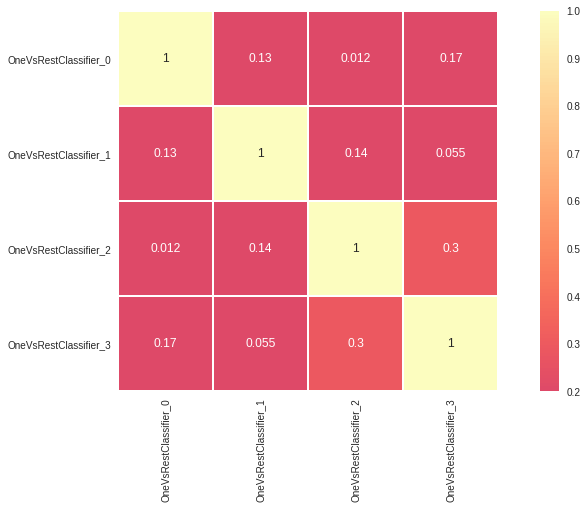

In [ ]:
stack_soft_plot = stack_models([gbc,dt,lightgbm,xgboost], plot=True)


## **Model Calibration**

In [ ]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8714,0.0,0.5500,0.8882,0.8233,0.1600
1,0.8571,0.0,0.5000,0.7347,0.7912,0.0000
2,0.8571,0.0,0.5000,0.7347,0.7912,0.0000
3,0.8571,0.0,0.5000,0.7347,0.7912,0.0000
4,0.8571,0.0,0.5000,0.7347,0.7912,0.0000
5,0.8429,0.0,0.5000,0.7104,0.7710,0.0000
6,0.8286,0.0,0.3277,0.7085,0.7638,-0.0256
7,0.8286,0.0,0.3277,0.7085,0.7638,-0.0256
8,0.8429,0.0,0.3333,0.7104,0.7710,0.0000
9,0.8406,0.0,0.4915,0.7293,0.7810,-0.0271


In [ ]:
plot_model(rf, plot='calibration')


SystemExit: ignored

In [ ]:
calibrated_rf = calibrate_model(rf)


IntProgress(value=0, description='Processing: ', max=14)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:11:18
Status,. . . . . . . . . . . . . . . . . .,Fitting Fold 1 of 10
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Accuracy,AUC,Recall,Prec.,F1,Kappa


ValueError: ignored

***Interpreting the Model***

In [ ]:
interpret_model()

SystemExit: ignored

**Predicting the Model**

In [ ]:
rf_holdout_pred = predict_model(rf)


**Saving the Model**

In [ ]:
load_saved_model = load_model('pycaret_model')
#load_experiment(experiment_name='pycaret_experiment'
#load_saved_exp = load_experiment(‘pycaret_experiment’)


**References**:


**Feature Engineering (correlation)**

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9


https://towardsdatascience.com/machine-learning-made-easier-with-pycaret-907e7124efe6

https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598


https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087



**Imbalanced Data:**


https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

**CatBoost**

https://catboost.ai/docs/concepts/python-usages-examples.html

**UK Government data**:

 http://data.dft.gov.uk/road-accidents-safety-data/